<a href="https://colab.research.google.com/github/d-roland/Fake-news-detection/blob/master/CS221_Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [149]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
import csv
from collections import Counter, defaultdict
from wordcloud import WordCloud
import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, CuDNNLSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from datetime import datetime
from statistics import mean
import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# **Gathering data**

## Integrating BuzzFeed Real News

In [7]:
bfreal = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_real_news_content.csv')
bfreal.shape

(91, 12)

In [8]:
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin..."
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F..."
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b..."
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict..."


In [9]:
bfreal.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,91,91,84,91,56,4,91,90,91
unique,91,91,91,91,87,65,14,53,4,90,90,91
top,Real_56-Webpage,Clinton: ‘The next 50 days will determine the ...,"\n\nPlastic glasses, knives, forks and food bo...",http://politi.co/2cP9WaV,http://static.politico.com/da/f5/44342c424c68b...,"Jack Shafer,Louis Nelson",http://politi.co,{'$date': 1474934400000},https://www.youtube.com/embed/7LUv7x5bXV4,http://static.politico.com/da/f5/44342c424c68b...,http://addictinginfo.com/2016/09/27/huffpo-jus...,"{""description"": ""Hillary Clinton kicked off a ..."
freq,1,1,1,1,3,5,32,2,1,2,1,1


In [10]:
for key,count in bfreal.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bfreal.shape[0]))

http://politi.co:	32
http://cnn.it:	23
http://abcn.ws:	9
http://rightwingnews.com:	7
http://eaglerising.com:	7
http://www.addictinginfo.org:	3
http://www.ifyouonlynews.com:	2
http://addictinginfo.org:	2
http://freedomdaily.com:	1
http://conservativebyte.com:	1
http://www.opposingviews.com:	1
http://winningdemocrats.com:	1
http://occupydemocrats.com:	1
https://www.washingtonpost.com:	1
Total Records:	91


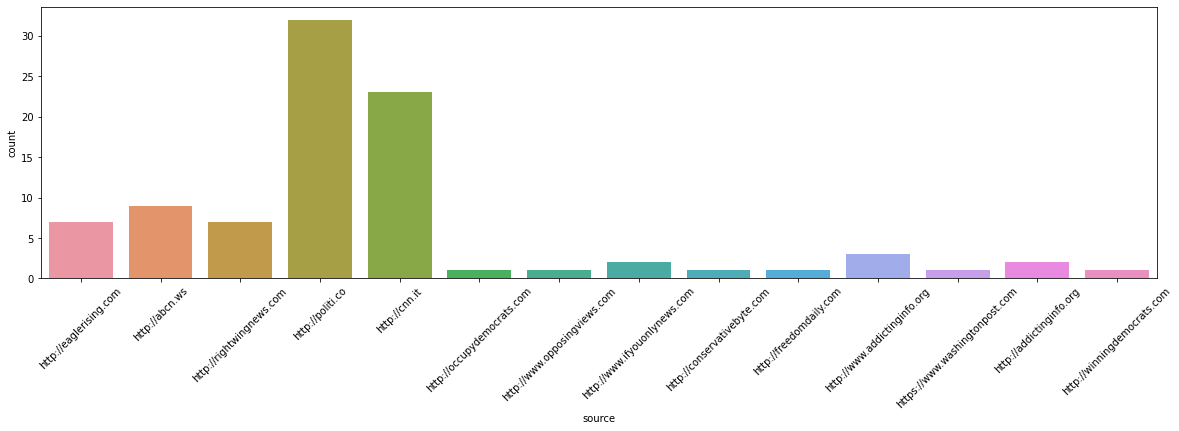

In [11]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bfreal)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [12]:
#checking for rows with empty text
[index for index,text in enumerate(bfreal.text.values) if str(text).strip() == '']

[]

Adding class indication, and an empty subject column, prior to merging with Fake-and-real-news dataset.

In [13]:
bfreal["class"]=1
bfreal["subject"]=''
bfreal.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin...",1,
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F...",1,
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam...",1,
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b...",1,
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict...",1,


Removing all polluting expressions in both text and title

In [0]:
#Seperating Publication info, from actual text
pollution_real = ["getty images", "⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_real:
    bfreal['title'] = bfreal['title'].str.replace(i , '')
    bfreal['text'] = bfreal['text'].str.replace(i , '')

## Integrating BuzzFeed Fake News

In [15]:
bffake = pd.read_csv('/content/drive/My Drive/CS221_Project/BuzzFeed_fake_news_content.csv')
bffake.shape

(91, 12)

In [16]:
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ..."
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis..."
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi..."
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ..."
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty..."


In [17]:
bffake.describe()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
count,91,91,91,83,81,57,83,77,21,81,80,91
unique,91,87,87,80,79,30,22,69,21,79,78,81
top,Fake_66-Webpage,A Hillary Clinton Administration May be Entire...,Website is Down For Maintenance,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,Terresa Monroe-hamilton,http://rightwingnews.com,{'$date': 1474588800000},https://www.youtube.com/embed/z9GptmyPn5A?rel=...,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,{}
freq,1,2,2,2,2,6,17,4,1,2,2,8


In [18]:
for key,count in bffake.source.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(bffake.shape[0]))

http://rightwingnews.com:	17
http://freedomdaily.com:	16
http://eaglerising.com:	11
http://occupydemocrats.com:	6
https://goo.gl:	3
http://www.addictinginfo.org:	3
http://www.thepoliticalinsider.com:	3
http://clashdaily.com:	2
http://www.proudcons.com:	2
http://allenwestrepublic.com:	2
http://winningdemocrats.com:	2
http://theblacksphere.net:	2
http://conservativetribune.com:	2
https://ihavethetruth.com:	2
http://usherald.com:	2
http://100percentfedup.com:	2
http://conservativebyte.com:	1
http://www.chicksontheright.com:	1
http://author.groopspeak.com:	1
http://author.addictinginfo.org:	1
http://www.yesimright.com:	1
http://addictinginfo.org:	1
Total Records:	91


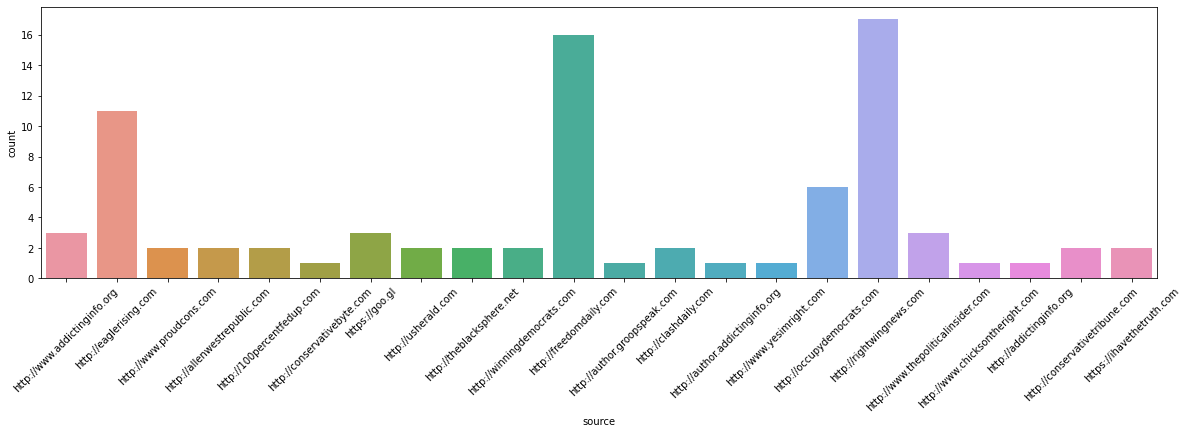

In [19]:
plt.figure(figsize=(20,5))
chart = sns.countplot("source", data=bffake)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [20]:
#checking for rows with empty text
[index for index,text in enumerate(bffake.text.values) if str(text).strip() == '']

[]

In [21]:
bffake["class"]=0
bffake["subject"]=''
bffake.head()

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data,class,subject
0,Fake_1-Webpage,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,http://www.addictinginfo.org/2016/09/19/proof-...,http://addictinginfo.addictinginfoent.netdna-c...,Wendy Gittleson,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://addictin...",http://addictinginfo.com/2016/09/19/proof-the-...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
1,Fake_10-Webpage,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,http://eaglerising.com/36899/charity-clinton-f...,http://eaglerising.com/wp-content/uploads/2016...,View All Posts,http://eaglerising.com,{'$date': 1474416521000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36899/charity-clinton-f...,"{""description"": ""The possibility that CHAI dis...",0,
2,Fake_11-Webpage,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,http://eaglerising.com/36880/a-hillary-clinton...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Tony Elliott",http://eaglerising.com,{'$date': 1474416638000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36880/a-hillary-clinton...,"{""description"": ""Hillary Clinton may be the fi...",0,
3,Fake_12-Webpage,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",http://www.addictinginfo.org/2016/09/19/trumps...,http://addictinginfo.addictinginfoent.netdna-c...,John Prager,http://www.addictinginfo.org,{'$date': 1474243200000},NaN,"http://i.imgur.com/JeqZLhj.png,http://2.gravat...",http://addictinginfo.com/2016/09/19/trumps-lat...,"{""publisher"": ""Addicting Info | The Knowledge ...",0,
4,Fake_13-Webpage,Website is Down For Maintenance,Website is Down For Maintenance,http://www.proudcons.com/clinton-foundation-ca...,NaN,NaN,http://www.proudcons.com,NaN,NaN,NaN,NaN,"{""og"": {""url"": ""http://www.proudcons.com"", ""ty...",0,


Removing all polluting expressions in both text and title

In [0]:
pollution_fake = ["getty images", "⋆ US Herald","– Eagle Rising", "The views expressed in this opinion article are solely those of their author and are not necessarily either shared or endorsed by EagleRising.com", " ⋆ Freedom Daily","Read More", "Authors:"]
for i in pollution_fake:
    bffake['title'] = bffake['title'].str.replace(i , '')
    bffake['text'] = bffake['text'].str.replace(i , '')

## Integrating Fake-and-real-news Real News

In [23]:
reald = pd.read_csv('/content/drive/My Drive/CS221_Project/True.csv')
reald.shape

(21417, 4)

In [24]:
reald.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [25]:
for key,count in reald.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(reald.shape[0]))

politicsNews:	11272
worldnews:	10145
Total Records:	21417


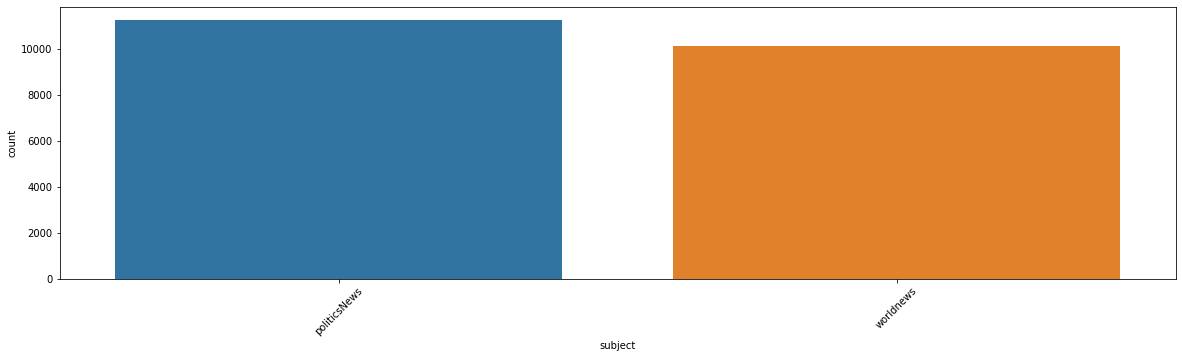

In [26]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=reald)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [27]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(reald.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of publication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)
#Thus we have list of indices where publisher is not mentioned
#lets check
reald.iloc[unknown_publishers].text

3488     The White House on Wednesday disclosed a group...
4358     Neil Gorsuch, President Donald Trump’s appoint...
4465     WASHINGTON The clock began running out this we...
5784     Federal appeals court judge Neil Gorsuch, the ...
6660     Republican members of Congress are complaining...
6823     Over the course of the U.S. presidential campa...
7922     After going through a week reminiscent of Napo...
8194     The following timeline charts the origin and s...
8195     Global health officials are racing to better u...
8247     U.S. President Barack Obama visited a street m...
8465     ALGONAC, MICH.—Parker Fox drifted out of the D...
8481     Global health officials are racing to better u...
8482     The following timeline charts the origin and s...
8505     Global health officials are racing to better u...
8506     The following timeline charts the origin and s...
8771     In a speech weighted with America’s complicate...
8970                                                    

In [28]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for idx,row in enumerate(reald.text.values):
    if idx in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

#Replace existing text column with new text
#add seperate column for publication info in case we want to use it later
reald["source"] = publisher
reald["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers
reald.head()

,title,text,subject,date,source
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [0]:
pollution_reald = ["/Getty Images", "Getty Images", "getty images", "Reuters"]
for i in pollution_reald:
    reald['title'] = reald['title'].str.replace(i , '')
    reald['text'] = reald['text'].str.replace(i , '')

In [29]:
#checking for rows with empty text
[index for index,text in enumerate(reald.text.values) if str(text).strip() == '']

[8970]

In [0]:
#dropping this record
reald = reald.drop(8970, axis=0)

In [31]:
#renaming date column before merging with FakenewsNet dataset, and adding a class column
reald["class"]=1
reald = reald.rename(columns={"date":"publish_date"})
reald.head()

,title,text,subject,publish_date,source,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,politicsNews,"December 29, 2017",WASHINGTON (Reuters),1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,politicsNews,"December 31, 2017",WASHINGTON (Reuters),1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,politicsNews,"December 30, 2017",WASHINGTON (Reuters),1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters),1


## Integrating Fake-and-real-news Fake News

In [32]:
faked = pd.read_csv('/content/drive/My Drive/CS221_Project/Fake.csv')
faked.shape

(23481, 4)

In [33]:
faked.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [34]:
for key,count in faked.subject.value_counts().iteritems():
    print("{}:\t{}".format(key, count))
    
print("Total Records:\t{}".format(faked.shape[0]))

News:	9050
politics:	6841
left-news:	4459
Government News:	1570
US_News:	783
Middle-east:	778
Total Records:	23481


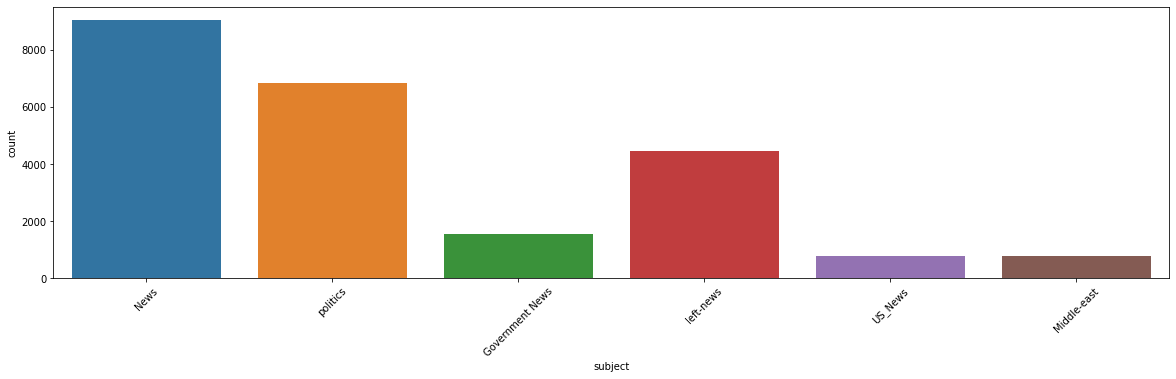

In [35]:
plt.figure(figsize=(20,5))
chart = sns.countplot("subject", data=faked)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [36]:
#checking for rows with empty text
empty_faked_index = [index for index,text in enumerate(faked.text.values) if str(text).strip() == '']
print("No of empty rows: {}".format(len(empty_faked_index)))
faked.iloc[empty_faked_index].tail()

No of empty rows: 630


,title,text,subject,date
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"
21873,(VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...,,left-news,"Apr 12, 2015"


In [37]:
#dropping this record
for i in empty_faked_index:
  faked = faked.drop(i, axis=0)

faked.shape

(22851, 4)

Removing polluting expressions in both title and text columns

In [0]:
pollution_faked = ["(VIDEO)", "[VIDEO]", "Photo by", "/Getty Images", "Getty Images", "Featured image", "pic.twitter.com"]
for i in pollution_faked:
    faked['title'] = faked['title'].str.replace(i , '')
    faked['text'] = faked['text'].str.replace(i , '')

In [39]:
#renaming date column before merging with FakenewsNet dataset, adding a class column and a source one set to "Unknown"
faked["class"]=0
faked["source"]="Unknown"
faked = faked.rename(columns={"date":"publish_date"})
faked.head()

,title,text,subject,publish_date,class,source
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0,Unknown
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0,Unknown
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0,Unknown
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0,Unknown
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0,Unknown


## Merging all 4 datasets into one

**Baseline**: merge title and text, and keep only the resulting value along with the class

In [40]:
bfreal_short = bfreal[["title", "text","class"]]
bfreal_short.head()

,title,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,1


In [41]:
bffake_short = bffake[["title", "text","class"]]
bffake_short.head()

,title,text,class
0,Proof The Mainstream Media Is Manipulating The...,I woke up this morning to find a variation of ...,0
1,Charity: Clinton Foundation Distributed “Water...,Former President Bill Clinton and his Clinton ...,0
2,A Hillary Clinton Administration May be Entire...,After collapsing just before trying to step in...,0
3,Trump’s Latest Campaign Promise May Be His Mos...,"Donald Trump is, well, deplorable. He’s sugges...",0
4,Website is Down For Maintenance,Website is Down For Maintenance,0


In [42]:
reald_short = reald[["title", "text","class"]]
reald_short.head()

,title,text,class
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction...,1
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fi...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links be...,1
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos to...,1
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Pos...,1


In [43]:
faked_short = faked[["title", "text","class"]]
faked_short.tail()

,title,text,class
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0
23480,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,0


In [44]:
dataset = bfreal_short.append([bffake_short, reald_short, faked_short], ignore_index=True)
dataset.shape

(44449, 3)

In [45]:
#Combining Title and Text
dataset["text"] = dataset["title"] + " " + dataset["text"]
dataset = dataset.drop(["title"], axis=1)
dataset.head()

,text,class
0,Another Terrorist Attack in NYC…Why Are we STI...,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...",1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",1


In [46]:
dataset.tail()

,text,class
44444,McPain: John McCain Furious That Iran Treated ...,0
44445,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44446,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44447,How to Blow $700 Million: Al Jazeera America F...,0
44448,10 U.S. Navy Sailors Held by Iranian Military ...,0


In [47]:
dataset.count()

text     44449
class    44449
dtype: int64

In [48]:
dataset["class"].value_counts()

0    22942
1    21507
Name: class, dtype: int64

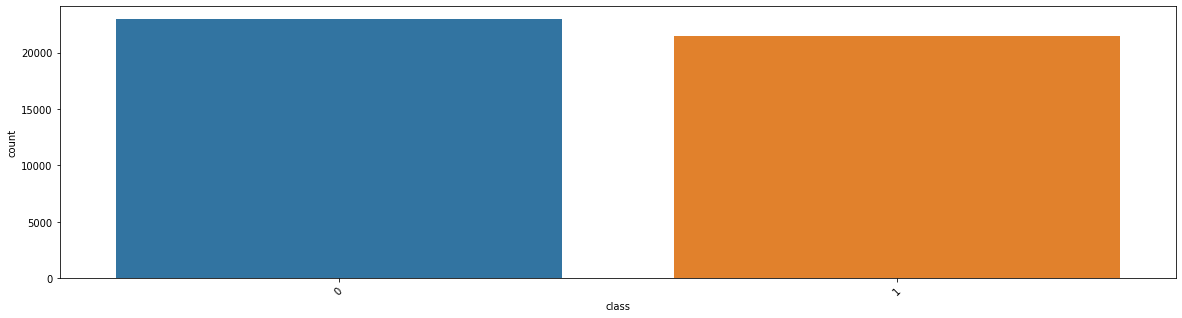

In [49]:
#Plotting total number of Fake and Real news
plt.figure(figsize=(20,5))
chart = sns.countplot("class", data=dataset)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [0]:
del bfreal, bfreal_short, bffake, bffake_short, reald, reald_short, faked, faked_short

# **Generating Oracle**

In [0]:
num_samples = 25
sampled = dataset.sample(n=num_samples)
sampled['text'].to_csv('/content/drive/My Drive/CS221_Project/oracle_data.csv', index=False)

After we've generated the file, we'd fill it out and then
run the following:

In [52]:
sampled = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_answers.csv')
guesses = pd.read_csv('/content/drive/My Drive/CS221_Project/oracle_data_filled_lowercase.csv')
guesses['roland'] = pd.to_numeric(guesses['roland'])
guesses['sathya'] = pd.to_numeric(guesses['sathya'])
accuracy = pd.DataFrame()
accuracy['roland'] = (sampled['class']==guesses['roland'])
accuracy['sathya'] = (sampled['class']==guesses['sathya'])
accuracy['max'] = (accuracy['sathya'] | accuracy['roland']) #picking the right answer if one of us chose it
accuracy['min'] = (accuracy['sathya'] & accuracy['roland']) #picking the wrong answer if one of us chose it
print("Roland accuracy: ", sum(accuracy['roland'])/num_samples)
print("Sathya accuracy: ", sum(accuracy['sathya'])/num_samples)
print("Maximum accuracy: ", sum(accuracy['max'])/num_samples)
print("Minimum accuracy: ", sum(accuracy['min'])/num_samples)

Roland accuracy:  0.52
Sathya accuracy:  0.52
Maximum accuracy:  0.56
Minimum accuracy:  0.48


# **Data Preprocessing**

## Data cleaning

In [0]:
"""
A utility function to remove numerical characters from the text.

"""

def remove_nums(text):
    text = ''.join([i for i in text if not i.isdigit()])         
    return text


"""
A utility function to remove URL links from the text.

"""

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


"""
A utility function to remove HTML tags from the text.

"""

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)


"""
A utility function to remove emojis from the text.

"""

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [0]:
dataset['text'] = dataset["text"].apply(lambda x: remove_nums(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_URL(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_html(x))
dataset['text'] = dataset["text"].apply(lambda x: remove_emoji(x))

In [0]:
%%capture
#!pip install spellchecker
#!pip install indexer
#!pip install pyspellchecker

In [0]:
# OPTIONAL - VERY SLOW - Spelling correction

#from spellchecker import SpellChecker

#spell = SpellChecker()
#def correct_spellings(text):
#    corrected_text = []
#    misspelled_words = spell.unknown(text.split())
#    for word in text.split():
#        if word in misspelled_words:
#            corrected_text.append(spell.correction(word))
#        else:
#            corrected_text.append(word)
#    return " ".join(corrected_text)

#dataset["text"].apply(lambda text: correct_spellings(text))
#dataset.head(10)

## Tokenization and stopwords removal

In [0]:
y = []
y = dataset["class"].values
#Converting X to format acceptable by gensim, removing stopwords and punctuation in the process
stop_words = set(nltk.corpus.stopwords.words("english"))
X = []
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in dataset["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

#del dataset

In [58]:
X[1][:10]

['donald',
 'trump',
 'drugs',
 'big',
 'factor',
 'charlotte',
 'protests',
 'less',
 'day',
 'protests']

In [59]:
#Confirming that X is a list of all news and y contains all classes
print(len(X), len(y))

44449 44449


In [60]:
#checking for rows with empty text
empty_X_lines = [index for index,text in enumerate(X) if text == []]
print(empty_X_lines)

[30956, 36727, 36728, 37030, 37031, 38550, 38551, 42838, 42839]


In [61]:
#Dropping those lines in both X and y
for i in reversed(empty_X_lines):
  del X[i]
  y = np.delete(y,i)

print(len(X), len(y))

44440 44440


## Dataset size fine tuning

In [62]:
#Optional - Removing news of less than 100 words
LOWER_BOUND = 100

lower_lines = []
lower_lines = [index for index,text in enumerate(X) if len(text)<LOWER_BOUND]

print(len(lower_lines)/len(X))

0.19284428442844284


In [63]:
#Dropping those lines in both X and y
for i in reversed(lower_lines):
  del X[i]
  y = np.delete(y,i)

print(len(X), len(y))

35870 35870


In [64]:
#Optional - Removing news of more than 700 words

UPPER_BOUND = 450

upper_lines = []
upper_lines = [index for index, text in enumerate(X) if len(text)>UPPER_BOUND]
print(len(upper_lines)/len(X))

0.11374407582938388


In [65]:
#Dropping those lines in both X and y
for i in reversed(upper_lines):
  del X[i]
  y = np.delete(y,i)

print(len(X), len(y))

31790 31790


In [66]:
#Identifying indexes of real and fake news
real_idx = [i for i,v in enumerate(y) if v == 1]
fake_idx = [i for i,v in enumerate(y) if v == 0]
print(len(real_idx), len(fake_idx))

13627 18163


In [0]:
#Making these two set of indexes of equal length
min_size = min(len(real_idx), len(fake_idx))
real_idx = random.sample(real_idx, min_size)
fake_idx = random.sample(fake_idx, min_size)

In [68]:
X_real = []
X_fake = []
X_real = [X[i] for i in real_idx]
X_fake = [X[j] for j in fake_idx]
print(len(X_real), len(X_fake))

13627 13627


In [69]:
X = []
y = []
X = X_real + X_fake
y = [1] * len(X_real) + [0] * len(X_fake)
print(len(X), len(y))

27254 27254


## Optional - Frequent words removal

In [70]:
# OPTIONAL - Removing frequent and rare words from X_real

cnt_real = Counter()
for news in X_real:
  for word in news:
    cnt_real[word] += 1

n_rare_words = 10
RAREWORDS_real = set([w for (w, wc) in cnt_real.most_common()[:-n_rare_words-1:-1]])
        
FREQWORDS_real = set([w for (w, wc) in cnt_real.most_common(15)])

print('Rare words in Real dataset:', RAREWORDS_real)
print('Frequent words in Real dataset:', FREQWORDS_real)

Rare words in Real dataset: {'idolatry', 'podgorica', 'outdone', 'megahertz', 'autopacific', 'reestablishing', 'swg', 'immigrations', 'jadiyetu', 'calabrese'}
Frequent words in Real dataset: {'people', 'states', 'last', 'republican', 'house', 'government', 'year', 'trump', 'state', 'also', 'said', 'united', 'president', 'would', 'new'}


In [71]:
X_real_freq = []
tmp = []
for news in X_real:
  filtered_words = [w.strip() for w in news if w not in FREQWORDS_real and w not in RAREWORDS_real]
  tmp.append(filtered_words)
X_real_freq.extend(tmp)

X_real_freq[1][:10]

['explosion',
 'kills',
 'three',
 'chadian',
 'peacekeepers',
 'northern',
 'mali',
 'three',
 'nations',
 'soldiers']

In [72]:
# OPTIONAL - Removing frequent and rare words from X_fake

cnt_fake = Counter()
for news in X_fake:
  for word in news:
    cnt_fake[word] += 1

n_rare_words = 10
RAREWORDS_fake = set([w for (w, wc) in cnt_fake.most_common()[:-n_rare_words-1:-1]])
        
FREQWORDS_fake = set([w for (w, wc) in cnt_fake.most_common(15)])

print('Rare words in Fake dataset:', RAREWORDS_fake)
print('Frequent words in Fake dataset:', FREQWORDS_fake)

Rare words in Fake dataset: {'copays', 'piped', 'caicedos', 'untapped', 'optimizes', 'shuddered', 'reversals', 'gaithersburg', 'uncompensated', 'coinsurance'}
Frequent words in Fake dataset: {'one', 'would', 'even', 'hillary', 'obama', 'clinton', 'trump', 'news', 'like', 'said', 'also', 'via', 'president', 'people', 'donald'}


In [73]:
X_fake_freq = []
tmp = []
for news in X_fake:
  filtered_words = [w.strip() for w in news if w not in FREQWORDS_fake and w not in RAREWORDS_fake]
  tmp.append(filtered_words)
X_fake_freq.extend(tmp)

X_fake_freq[1][:10]

['democrats',
 'wall',
 'lawbreakers',
 'wall',
 'keep',
 'bernie',
 'sanders',
 'fans',
 'democrats',
 'brought']

In [74]:
#Recreating X with removed frequencies
X_freq = X_real_freq + X_fake_freq
y_freq = [1] * len(X_real_freq) + [0] * len(X_fake_freq)
print(len(X_freq), len(y_freq))

#Uncomment the following if you want to replace the original "X" to impact all following steps with removed frequencies
X = []
y = []
X = X_freq
y = y_freq
X_real = []
X_fake = []
X_real = X_real_freq
X_fake = X_fake_freq

27254 27254


## Optional - Keeping only words from common dictionary

In [75]:
#Optional - Keeping only words from common dictionary
real_words = defaultdict(int)
fake_words = defaultdict(int)
common_words = []

print("Before dictionary adjustment, Size of X_real: ", len(X_real), "Size of X_fake: ", len(X_fake))
for news in X_real:
  for word in news:
    real_words[word] += 1

for news in X_fake:
  for word in news:
    fake_words[word] += 1

list_real_words = list(real_words.keys())
list_fake_words = list(fake_words.keys())

print("Dictionary size for X_real: ", len(list_real_words), "Dictionary size for X_fake: ", len(list_fake_words))

common_words = [word for word in list_real_words if word in list_fake_words]

print("Total unique words common to both dictionaries: ",len(common_words))

Before dictionary adjustment, Size of X_real:  13627 Size of X_fake:  13627
Dictionary size for X_real:  55806 Dictionary size for X_fake:  66229
Total unique words common to both dictionaries:  31931


In [76]:
#Analizing common words with very high frequency in one corpus vs the other
vocab_frequency = defaultdict(int)
for word in common_words:
  vocab_frequency[word] = round(np.abs(real_words[word]-fake_words[word])/max(len(real_words), len(fake_words)),2)

vocab_frequency = {k: v for k, v in sorted(vocab_frequency.items(), key=lambda item: item[1], reverse = True)}

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

most_frequent = take(50, vocab_frequency.items())
print(most_frequent)

[('minister', 0.09), ('china', 0.09), ('video', 0.08), ('us', 0.08), ('america', 0.07), ('reuters', 0.07), ('north', 0.07), ('court', 0.07), ('know', 0.07), ('wednesday', 0.06), ('foreign', 0.06), ('party', 0.06), ('told', 0.06), ('two', 0.06), ('thursday', 0.06), ('military', 0.06), ('percent', 0.06), ('senate', 0.06), ('security', 0.06), ('tuesday', 0.06), ('right', 0.06), ('eu', 0.06), ('officials', 0.06), ('get', 0.06), ('black', 0.06), ('korea', 0.06), ('watch', 0.06), ('week', 0.05), ('friday', 0.05), ('month', 0.05), ('including', 0.05), ('tax', 0.05), ('trade', 0.05), ('american', 0.05), ('election', 0.05), ('fox', 0.05), ('fact', 0.05), ('going', 0.05), ('could', 0.05), ('talks', 0.05), ('monday', 0.05), ('man', 0.05), ('iran', 0.05), ('really', 0.05), ('gop', 0.05), ('deal', 0.04), ('since', 0.04), ('forces', 0.04), ('go', 0.04), ('former', 0.04)]


In [77]:
#Optional - removing words frequent only in one corpus from common dictionary
most_frequent_words = []
most_frequent_words = [w for w in vocab_frequency.keys()]

for word in most_frequent_words:
  if float(round(np.abs(real_words[word]-fake_words[word])/max(len(real_words), len(fake_words)),2)) > 0.01:
    common_words.remove(word)

print(len(common_words))

31605


In [79]:
X_real = [[word for word in news if word in common_words] for news in X_real]
X_fake = [[word for word in news if word in common_words] for news in X_fake]
"""
for news in X_real:
    for word in common_words:
        if word in news:
            news = [item.replace(word, "") for item in news]

for news in X_fake:
    for word in common_words:
        if word in news:
            news = [item.replace(word, "") for item in news]
"""
print("After dictionary adjustment, Size of X_real: ", len(X_real), "Size of X_fake: ", len(X_fake))

After dictionary adjustment, Size of X_real:  13627 Size of X_fake:  13627


In [80]:
#Check number of possible empty lines in both corpus after dictionary cleaning
empty_X_lines_real = [index for index,text in enumerate(X_real) if text == []]
empty_X_lines_fake = [index for index,text in enumerate(X_fake) if text == []]
print("Real: ", empty_X_lines_real, "Fake :", empty_X_lines_fake)

Real:  [] Fake : []


In [0]:
X = []
y = []
X = X_real + X_fake
y = [1] * len(X_real) + [0] * len(X_fake)

In [82]:
print(len(X), len(y))

27254 27254


In [0]:
#put X back together and save as a CSV for input into BERT.
bert_dataset = []
for entry in X:
  bert_dataset.append(' '.join(entry))
bert_dataset = np.asarray(bert_dataset) 
bert_dataset = pd.DataFrame(data=bert_dataset, columns=["text"])
bert_dataset['class'] = y

In [84]:
bert_dataset.to_csv('/content/drive/My Drive/CS221_Project/bert_dataset.csv', index=False)
bert_dataset.head(10)

,text,class
0,pope arrives colombia help heal wounds pope fr...,1
1,explosion kills peacekeepers mali soldiers cha...,1
2,debate employing half lobbyists report half re...,1
3,launches opioid fraud detection unit attorney ...,1
4,justice affirms evidence wiretapped justice ev...,1
5,defends candidate moore despite misconduct all...,1
6,venezuela frees jailed opponents christmas ges...,1
7,red cross says staff member sudan ambush red c...,1
8,abe vows put education balance vowed education...,1
9,kasich democrat hickenlooper mull joint run oh...,1


## Optional - Lemmatization

In [0]:
# OPTIONAL - Lemmatization while respecting the POS

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(lemmatizer.lemmatize(word))
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

bert_dataset["text"] = bert_dataset["text"].apply(lambda text: lemmatize_sentence(text))
bert_dataset.head(10)

# **Vectorization**

## Via TF-IDF

In [85]:
#Manually generating Train/Test sets
test_set_size = 0.15*float(len(bert_dataset))
test_idx = random.sample(range(len(bert_dataset)),int(test_set_size))

X_test = []
y_test = []
for idx in test_idx:
  X_test.append(bert_dataset["text"].iloc[idx])
  y_test.append(bert_dataset["class"].iloc[idx])

X_test = np.array(X_test)
y_test = np.array(y_test)

train_idx = [j for j in range(len(bert_dataset))]
for i in test_idx:
  train_idx.remove(i)
  
X_train = []
y_train = []
for idx in train_idx:
  X_train.append(bert_dataset["text"].iloc[idx])
  y_train.append(bert_dataset["class"].iloc[idx])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(len(X_train), len(X_test))
del test_idx, train_idx

23166 4088


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [87]:
X_train_tfidf.shape

(23166, 31554)

## Via Word2Vec

In [0]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=5)

In [90]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each word by a 100dim vector.

27005

In [0]:
#see a sample vector for random word 
#w2v_model["clinton"]

In [0]:
#w2v_model.wv.most_similar("foundation")

In [93]:
# visualize embeddings  ==> Takes too long given dictionary size. Will rather try Kmeans on vectors in Data Analysis
"""
from sklearn.manifold import TSNE

words = w2v_model.wv.index2word
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(12, 6))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')
"""

"\nfrom sklearn.manifold import TSNE\n\nwords = w2v_model.wv.index2word\nwvs = w2v_model.wv[words]\n\ntsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)\nnp.set_printoptions(suppress=True)\nT = tsne.fit_transform(wvs)\nlabels = words\n\nplt.figure(figsize=(12, 6))\nplt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')\nfor label, x, y in zip(labels, T[:, 0], T[:, 1]):\n    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')\n"

## Tokenization with Keras

In [0]:
# Tokenizing Text -> Representing each word by a number
# Mapping of original word to number is preserved in word_index property of tokenizer

#Tokenizer applies basic processing like changing it to lower case, explicitely setting that as True even if already done before

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(lower=True)
tokenizer.fit_on_texts(X)

X_tok = tokenizer.texts_to_sequences(X)

In [95]:
# lets check the first 10 words of first news
#every word has been represented with a number
X_tok[0][:10]

[1100, 9533, 2772, 23, 6917, 5060, 1100, 2014, 1385, 2772]

In [96]:
#Lets check few word to numerical representation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print("{} -> {}".format(word, num))
    if num == 10:
        break        

campaign -> 1
first -> 2
years -> 3
may -> 4
say -> 5
police -> 6
republicans -> 7
many -> 8
according -> 9
called -> 10


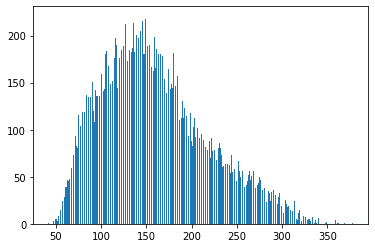

In [97]:
# Making histogram for no of words in news shows that most news article are under 700 words.
plt.hist([len(x) for x in X_tok], bins=500)
plt.show()

In [98]:
# Most of the news have less than 700 words
nos = np.array([len(x) for x in X_tok])
print(len(nos[nos  < UPPER_BOUND])/len(X_tok))

1.0


In [99]:
print(len(nos[nos  > UPPER_BOUND])/len(X_tok))

0.0


In [0]:
#Lets keep all news to 700, add padding to news with less than 700 words and truncating long ones
maxlen = 200 

#Making all news of size maxlen defined above, padding with 0 when needed
X_tok = pad_sequences(X_tok, maxlen=maxlen)

In [101]:
#Checking
len(X_tok[0])

200

In [0]:
#Saving this tokenized and vectorized version to file
#with open('/content/drive/My Drive/CS221_Project/X_tok.csv', 'w') as myfile:
#    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#    wr.writerow(X_tok)

In [0]:
X_train_tok, X_test_tok, y_train_tok, y_test_tok = train_test_split(X_tok, y, test_size = 0.15) 

# **Modelization** 

## Naïve Bayes model

In [0]:
from sklearn.naive_bayes import MultinomialNB

On basic Keras tokenized input

In [0]:
naive_bayes_model_tok = MultinomialNB().fit(X_train_tok,y_train_tok)

In [106]:
predictions_nb_tok = naive_bayes_model_tok.predict(X_test_tok)
print(classification_report(y_test_tok, predictions_nb_tok))

              precision    recall  f1-score   support

           0       0.53      0.63      0.57      2065
           1       0.53      0.43      0.48      2024

    accuracy                           0.53      4089
   macro avg       0.53      0.53      0.52      4089
weighted avg       0.53      0.53      0.52      4089



On TF-IDF vectorized input

In [0]:
naive_bayes_model = MultinomialNB().fit(X_train_tfidf,y_train)

In [108]:
train_acc = metrics.accuracy_score(y_train, naive_bayes_model.predict(X_train_tfidf))
print("Training accuracy: ", train_acc)

Training accuracy:  0.9225589225589226


In [109]:
#Model Evaluation
predictions = naive_bayes_model.predict(X_test_tfidf)
print(predictions)

[0 0 1 ... 0 0 0]


In [110]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2056
           1       0.91      0.91      0.91      2032

    accuracy                           0.91      4088
   macro avg       0.91      0.91      0.91      4088
weighted avg       0.91      0.91      0.91      4088



## Support Vector Machine

In [0]:
from sklearn.svm import SVC

On basic Keras tokenized input

In [0]:
# Doesn't seem to work well. Likely due to lack of efficient features for the SVC model

#linear_svm_classifier_tok = SVC(kernel = "linear").fit(X_train_tok, y_train_tok)

In [0]:
#predictions_svm_tok = linear_svm_classifier_tok.predict(X_test_tok)
#print(classification_report(y_test_tok, predictions_svm_tok))

On TF-IDF vectorized input

In [0]:
linear_svm_classifier_tfidf = SVC(kernel = "linear").fit(X_train_tfidf,y_train)

In [115]:
train_acc_svm = metrics.accuracy_score(y_train, linear_svm_classifier_tfidf.predict(X_train_tfidf))
print("Training accuracy: ", train_acc_svm)

Training accuracy:  0.9915824915824916


In [116]:
predictions_svm_tfidf = linear_svm_classifier_tfidf.predict(X_test_tfidf)
print(predictions_svm_tfidf)

[0 0 1 ... 0 1 0]


In [117]:
print(classification_report(y_test, predictions_svm_tfidf))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2056
           1       0.97      0.97      0.97      2032

    accuracy                           0.97      4088
   macro avg       0.97      0.97      0.97      4088
weighted avg       0.97      0.97      0.97      4088



## Simple Neural Network

In [0]:
# Embedding Layer used in Keras creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [0]:
# Function to create weight matrix between word-index and vectors from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        try: 
          weight_matrix[i] = model[word]
        except:
          pass
    return weight_matrix

In [0]:
#Getting embedding vectors from word2vec and using it as weights of non-trainable keras embedding layer
#This embedding layer accepts numerical-token of word and outputs corresponding vector to inner layer.
#It sends vector of zeros to next layer for unknown words which would be tokenized to 0.
#Input length of embedding Layer is the length of each news (700 now due to padding and truncating)
%%capture
#del embedding_vectors
embedding_vectors = get_weight_matrix(w2v_model, word_index)

In [0]:
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
dnn_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [0]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

dnn_history = dnn_model.fit(X_train_tok, y_train_tok, epochs=10, validation_split = 0.2, \
                        callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

In [0]:
plt.plot(dnn_history.history['loss'])
plt.plot(dnn_history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
dnn_results = dnn_model.evaluate(X_test_tok, y_test_tok, batch_size=128)

print('Regular dense network - test loss: {}'.format(dnn_results[0]))
print('Regular dense network - test accuracy: {}'.format(dnn_results[1]))

In [0]:
dnn_pred = (dnn_model.predict(X_test_tok) >= 0.5).astype("int")

print("Model type: Regular dense neural network.")
print(classification_report(y_test_tok, dnn_pred))

In [0]:
print(confusion_matrix(y_test_tok, dnn_pred))

## Many to one LSTM

In [0]:
#Defining Neural Network
lstm_model = Sequential()
#Non-trainable embeddidng layer
lstm_model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
lstm_model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))
lstm_model.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

#del embedding_vectors

In [166]:
lstm_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          3160600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_9 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 3,290,849
Trainable params: 130,249
Non-trainable params: 3,160,600
_________________________________________________________________


In [167]:
early_stopping_callback_loss = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 1)
early_stopping_callback_val_loss = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 1)

lstm_history = lstm_model.fit(X_train_tok, y_train_tok, validation_split=0.2, epochs=6, \
                         callbacks = [early_stopping_callback_loss, early_stopping_callback_val_loss], verbose=1)

Train on 18532 samples, validate on 4633 samples
Epoch 1/6
18532/18532 [==============================] - 229s 12ms/sample - loss: 0.3328 - acc: 0.8562 - val_loss: 0.2374 - val_acc: 0.9063
Epoch 2/6
18532/18532 [==============================] - 233s 13ms/sample - loss: 0.2493 - acc: 0.8960 - val_loss: 0.2041 - val_acc: 0.9186
Epoch 3/6
18532/18532 [==============================] - 233s 13ms/sample - loss: 0.2110 - acc: 0.9139 - val_loss: 0.1797 - val_acc: 0.9307
Epoch 4/6
18532/18532 [==============================] - 233s 13ms/sample - loss: 0.1800 - acc: 0.9311 - val_loss: 0.1613 - val_acc: 0.9357
Epoch 5/6
18532/18532 [==============================] - 229s 12ms/sample - loss: 0.1594 - acc: 0.9378 - val_loss: 0.1442 - val_acc: 0.9422
Epoch 6/6
18532/18532 [==============================] - 230s 12ms/sample - loss: 0.1352 - acc: 0.9477 - val_loss: 0.1313 - val_acc: 0.9508


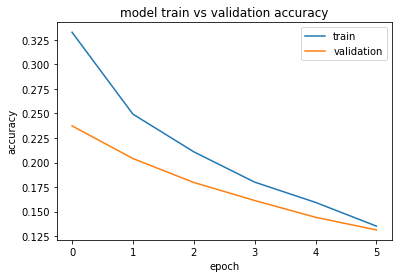

In [168]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model train vs validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [0]:
#Prediction is in probability of news being real, so converting into classes
lstm_pred = (lstm_model.predict(X_test_tok) >= 0.5).astype("int")

In [170]:
print(classification_report(y_test_tok, lstm_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      2065
           1       0.94      0.95      0.94      2024

    accuracy                           0.94      4089
   macro avg       0.94      0.94      0.94      4089
weighted avg       0.94      0.94      0.94      4089



In [171]:
print(confusion_matrix(y_test_tok, lstm_pred))

[[1946  119]
 [ 108 1916]]


## Bert 

Leveraging work from [this colab](https://colab.sandbox.google.com/drive/1W8yYgQJ6AAvwZ3AdfuPDLirqXOtHbmuO#scrollTo=6o2a5ZIvRcJq)

In [185]:
!pip install bert-tensorflow

     |████████████████████████████████| 71kB 2.6MB/s 


In [0]:
%load_ext tensorboard

In [187]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

In [188]:
# Set the output directory for saving model file
# Optionally, set a GCP bucket location

OUTPUT_DIR = '/content/drive/My Drive/CS221_Project/logs'#@param {type:"string"}
#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = False #@param {type:"boolean"}
#@markdown Set USE_BUCKET and BUCKET if you want to (optionally) store model output on GCP bucket.
USE_BUCKET = False #@param {type:"boolean"}
BUCKET = 'BUCKET_NAME' #@param {type:"string"}

if USE_BUCKET:
  OUTPUT_DIR = 'gs://{}/{}'.format(BUCKET, OUTPUT_DIR)
  from google.colab import auth
  auth.authenticate_user()

if DO_DELETE:
  try:
    tf.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    # Doesn't matter if the directory didn't exist
    pass
tf.gfile.MakeDirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))


***** Model output directory: /content/drive/My Drive/CS221_Project/logs *****


In [0]:
#Import dataset file if not done already
dataset_processed = pd.read_csv('/content/drive/My Drive/CS221_Project/bert_dataset.csv')

In [190]:
train_df = dataset_processed.sample(frac=0.7, replace=False, random_state=1)
val_df = dataset_processed.sample(frac=0.15, replace=False, random_state=1)
test_df = dataset_processed.sample(frac=0.15, replace=False, random_state=1)
print(train_df.shape, val_df.shape, test_df.shape)

(19078, 2) (4088, 2) (4088, 2)


In [0]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this example
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

dev_InputExamples = val_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

test_InputExamples = test_df.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x['text'], 
                                                                   text_b = None, 
                                                                   label = x['class']), axis = 1)

In [192]:
# In order to preprocess the data, we'll load a vocabulary file and lowercasing information directly from the BERT tf hub module
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer_bert = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [193]:
tokenizer_bert.tokenize("betsy devos gets skewered after dept. of education posts embarrassingly misspelled tweets donald trump s education department is pathetic now that betsy devos is in control, and this proves it.devos first week as secretary of education has been terrible to say the least.first, she was blocked from entering a public school by protesters and ran away. then she posted a tweet jokingly asking where the pencils are, which drew a sharp rebuke from teachers, who did not find her joke funny because they usually have to buy their own school supplies for their classrooms.and so, the department of education under devos rule is off to a rough start, and it got downright embarrassing on sunday as americans watched in horror as the education department proceeded to post twitter messages containing misspelled words.seriously. this is the f*cking department of education we are talking about. spelling should be in their wheelhouse. but because of trump and devos, that skill has apparently been lost.in celebration of black history month, the department of education decided to recognize and quote w.e.b. du bois. it did not go well.education must not simply teach work it must teach life. w.e.b. debois /re4cwkpsfa us dept of education (@usedgov) february 12, 2017that s right. devos and her team actually misspelled du bois name. and mockery and outrage rained down upon them for it.welp, this is a foreshadowing of what #betsydevos is going to usher in @usedgov. ffs! it s #blackhistorymonth too!??w. e. b. du bois?? /qkhyauyp6i khary penebaker (@kharyp) february 12, 2017@usedgov looks like @betsydevos is in charge now! /paajszsusl mike flacy (@mikeflacy) february 12, 2017.@usedgov *w.e.b. du boisall good. not like this is the official twitter for the us department of education. ? ryan wyatt (@fwiz) february 12, 2017@usedgov i am glad my public school teachers taught me how to properly spell the names of noted scholars!! maris kreizman (@mariskreizman) february 12, 2017@usedgov omg, it s dubois. who is in charge over there? oh, wait, i get it. jennifer morgan (@profjlmorgan) february 12, 2017.@usedgov first y all thought frederick douglass was alive, now you can t spell du bois. this bodes well for an already faltering system. mehreen kasana (@mehreenkasana) february 12, 2017hilarious, @usedgov. it s either a terrible mistake or a perverse foray into humor. his name is w.e.b. du bois. screenshot saved. /dfdv887rne jeffrey guterman (@jeffreyguterman) february 12, 2017@jeffreyguterman @usedgov is @betsydevos in charge of social media content too? was she distracted by a grizzly? ? @pc7 (@pjcc777) february 12, 2017@usedgov how the hell do you misspell his name? if this isn t foreshadowing the shitstorm of #betsydevos, then i don t know what is s vion (@savionwright) february 12, 2017i see they left ms. duvos in charge of the @usedgov twitter feed /sw0scgm49u jason tocci (@jasont) february 12, 2017protesters should ve let @betsydevos into the school long enough to learn how to spell his name correctly @usedgovhttps://t.co/pdzsgu5xev carlton banksy (@rtyson82) february 12, 2017and if that wasn t enough, the department of education posted a corrected version and then posted an apology tweet that was also misspelled.again, seriously. education must not simply teach work it must teach life. w.e.b. du bois /hsg4r1rlhh us dept of education (@usedgov) february 12, 2017 our deepest apologizes /0staogo3fd josh billinson (@jbillinson) february 12, 2017even reading rainbow star levar burton chimed in.heaven help us! the dept. of education misspelled dubois #bydhttmwfi https://t.co/pt6i1em8an levar burton (@levarburton) february 12, 2017betsy devos hasn t even been in charge for a full week and she has already repeatedly proved that while money can buy a cabinet seat, in her case it could not buy a decent education. via chip somodevilla")

['betsy',
 'dev',
 '##os',
 'gets',
 'sk',
 '##ew',
 '##ered',
 'after',
 'dept',
 '.',
 'of',
 'education',
 'posts',
 'embarrassing',
 '##ly',
 'miss',
 '##pel',
 '##led',
 't',
 '##wee',
 '##ts',
 'donald',
 'trump',
 's',
 'education',
 'department',
 'is',
 'pathetic',
 'now',
 'that',
 'betsy',
 'dev',
 '##os',
 'is',
 'in',
 'control',
 ',',
 'and',
 'this',
 'proves',
 'it',
 '.',
 'dev',
 '##os',
 'first',
 'week',
 'as',
 'secretary',
 'of',
 'education',
 'has',
 'been',
 'terrible',
 'to',
 'say',
 'the',
 'least',
 '.',
 'first',
 ',',
 'she',
 'was',
 'blocked',
 'from',
 'entering',
 'a',
 'public',
 'school',
 'by',
 'protesters',
 'and',
 'ran',
 'away',
 '.',
 'then',
 'she',
 'posted',
 'a',
 't',
 '##wee',
 '##t',
 'joking',
 '##ly',
 'asking',
 'where',
 'the',
 'pencil',
 '##s',
 'are',
 ',',
 'which',
 'drew',
 'a',
 'sharp',
 're',
 '##bu',
 '##ke',
 'from',
 'teachers',
 ',',
 'who',
 'did',
 'not',
 'find',
 'her',
 'joke',
 'funny',
 'because',
 'they',
 'usu

In [0]:
# label_list is the list of labels, i.e. True, False or 0, 1
label_list = [True, False]

In [195]:
# We'll set sequences to be at most 128 tokens long (due to memory restriction)
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
dev_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
test_features = bert.run_classifier.convert_examples_to_features(test_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)

INFO:tensorflow:Writing example 0 of 19078


INFO:tensorflow:Writing example 0 of 19078


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] loretta lynch gives radical protesters pep talk voice important eric holder dress eric holder ball rolling used taxpayer dollars pay protest tray ##von martin controversy loretta lynch carry torch injustice op ##pressed capable color ##bl ##ind justice desire punish disagree ##s radical ideology stronger desire honest justice served movement discouraged use lawful actions cover he ##ino ##us violence attorney loretta lynch encouragement radical movement came hours five officers gunn ##ed six wounded african radical attacker protest dallas throughout calls protests suggestions cops blamed high number african interactions enforcement calls less violence protests events across feeling sense uncertainty fear feelings understand ##able justified answer must violence answer must violence lynch rather answer must action calm peaceful collaborative determined action calm peaceful collaborative determined action must continue working [SEP]


INFO:tensorflow:tokens: [CLS] loretta lynch gives radical protesters pep talk voice important eric holder dress eric holder ball rolling used taxpayer dollars pay protest tray ##von martin controversy loretta lynch carry torch injustice op ##pressed capable color ##bl ##ind justice desire punish disagree ##s radical ideology stronger desire honest justice served movement discouraged use lawful actions cover he ##ino ##us violence attorney loretta lynch encouragement radical movement came hours five officers gunn ##ed six wounded african radical attacker protest dallas throughout calls protests suggestions cops blamed high number african interactions enforcement calls less violence protests events across feeling sense uncertainty fear feelings understand ##able justified answer must violence answer must violence lynch rather answer must action calm peaceful collaborative determined action calm peaceful collaborative determined action must continue working [SEP]


INFO:tensorflow:input_ids: 101 28493 11404 3957 7490 13337 27233 2831 2376 2590 4388 9111 4377 4388 9111 3608 5291 2109 26980 6363 3477 6186 11851 17789 3235 6704 28493 11404 4287 12723 21321 6728 19811 5214 3609 16558 22254 3425 4792 16385 21090 2015 7490 13165 6428 4792 7481 3425 2366 2929 22585 2224 26410 4506 3104 2002 5740 2271 4808 4905 28493 11404 15846 7490 2929 2234 2847 2274 3738 22079 2098 2416 5303 3060 7490 17346 6186 5759 2802 4455 8090 15690 10558 11248 2152 2193 3060 10266 7285 4455 2625 4808 8090 2824 2408 3110 3168 12503 3571 5346 3305 3085 15123 3437 2442 4808 3437 2442 4808 11404 2738 3437 2442 2895 5475 9379 12317 4340 2895 5475 9379 12317 4340 2895 2442 3613 2551 102


INFO:tensorflow:input_ids: 101 28493 11404 3957 7490 13337 27233 2831 2376 2590 4388 9111 4377 4388 9111 3608 5291 2109 26980 6363 3477 6186 11851 17789 3235 6704 28493 11404 4287 12723 21321 6728 19811 5214 3609 16558 22254 3425 4792 16385 21090 2015 7490 13165 6428 4792 7481 3425 2366 2929 22585 2224 26410 4506 3104 2002 5740 2271 4808 4905 28493 11404 15846 7490 2929 2234 2847 2274 3738 22079 2098 2416 5303 3060 7490 17346 6186 5759 2802 4455 8090 15690 10558 11248 2152 2193 3060 10266 7285 4455 2625 4808 8090 2824 2408 3110 3168 12503 3571 5346 3305 3085 15123 3437 2442 4808 3437 2442 4808 11404 2738 3437 2442 2895 5475 9379 12317 4340 2895 5475 9379 12317 4340 2895 2442 3613 2551 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] say firm gave terrorists anti propaganda major fundraiser tickets fundraiser hosted firm banned caught giving terror suspects anti propaganda mere per stuff voted yes preserving ha ##be ##as corpus guantanamo detainees sen spec ##ter amendment stricken provision regarding ha ##be ##as review underlying authorized trial violations lindsey graham say floor graham asked enemy prisoners bring lawsuit known fighting protecting enemy prisoner access courts non ##cit ##ize ##n enemy combat ##ant terrorist bring lawsuit fighting behalf judge ability historically reserved safer constitution ha ##be ##as corpus shall suspended unless cases rebellion invasion public safety may require either rebellion invasion hard basic principle constitutional suspend writ ha ##be ##as corpus evidence pointed danger nation voted yes voted attorney defended prisoners reward ##ing major fundraiser [SEP]


INFO:tensorflow:tokens: [CLS] say firm gave terrorists anti propaganda major fundraiser tickets fundraiser hosted firm banned caught giving terror suspects anti propaganda mere per stuff voted yes preserving ha ##be ##as corpus guantanamo detainees sen spec ##ter amendment stricken provision regarding ha ##be ##as review underlying authorized trial violations lindsey graham say floor graham asked enemy prisoners bring lawsuit known fighting protecting enemy prisoner access courts non ##cit ##ize ##n enemy combat ##ant terrorist bring lawsuit fighting behalf judge ability historically reserved safer constitution ha ##be ##as corpus shall suspended unless cases rebellion invasion public safety may require either rebellion invasion hard basic principle constitutional suspend writ ha ##be ##as corpus evidence pointed danger nation voted yes voted attorney defended prisoners reward ##ing major fundraiser [SEP]


INFO:tensorflow:input_ids: 101 2360 3813 2435 15554 3424 10398 2350 28536 9735 28536 4354 3813 7917 3236 3228 7404 13172 3424 10398 8210 2566 4933 5444 2748 15224 5292 4783 3022 13931 23094 26485 12411 28699 3334 7450 16654 9347 4953 5292 4783 3022 3319 10318 9362 3979 13302 17518 5846 2360 2723 5846 2356 4099 5895 3288 9870 2124 3554 8650 4099 7267 3229 5434 2512 26243 4697 2078 4099 4337 4630 9452 3288 9870 3554 6852 3648 3754 7145 9235 13726 4552 5292 4783 3022 13931 4618 6731 4983 3572 7417 5274 2270 3808 2089 5478 2593 7417 5274 2524 3937 6958 6543 28324 25697 5292 4783 3022 13931 3350 4197 5473 3842 5444 2748 5444 4905 8047 5895 10377 2075 2350 28536 102 0 0 0 0


INFO:tensorflow:input_ids: 101 2360 3813 2435 15554 3424 10398 2350 28536 9735 28536 4354 3813 7917 3236 3228 7404 13172 3424 10398 8210 2566 4933 5444 2748 15224 5292 4783 3022 13931 23094 26485 12411 28699 3334 7450 16654 9347 4953 5292 4783 3022 3319 10318 9362 3979 13302 17518 5846 2360 2723 5846 2356 4099 5895 3288 9870 2124 3554 8650 4099 7267 3229 5434 2512 26243 4697 2078 4099 4337 4630 9452 3288 9870 3554 6852 3648 3754 7145 9235 13726 4552 5292 4783 3022 13931 4618 6731 4983 3572 7417 5274 2270 3808 2089 5478 2593 7417 5274 2524 3937 6958 6543 28324 25697 5292 4783 3022 13931 3350 4197 5473 3842 5444 2748 5444 4905 8047 5895 10377 2075 2350 28536 102 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] zealand jet fuel increased calls navy beat shortage zealand partially ease fuel ratio ##ning industry sign five day long fuel shortage caused travel disruption ##s sub ##si ##ding flights cancelled zealand largest disrupt ##ing thousands travellers day single privately owned pipeline carries jet fuel refinery airport damaged carrier zealand flights run usual cancellation ##s first airline fuel allocation ##s rise midnight andrew manager mob ##il zealand ltd customers refinery operator refining travel restrictions lifted business innovation employment spoke ##sw ##oman carolyn tre ##main zealand industry taken series try contain fuel ratio ##ning calling help truck supplies fuel set industry handle fallout zealand navy vessel ferry diesel fuel around rushes alleviate shortage run saturday ship transport diesel equivalent tanker ##s enable industry focus providing jet fuel airport [SEP]


INFO:tensorflow:tokens: [CLS] zealand jet fuel increased calls navy beat shortage zealand partially ease fuel ratio ##ning industry sign five day long fuel shortage caused travel disruption ##s sub ##si ##ding flights cancelled zealand largest disrupt ##ing thousands travellers day single privately owned pipeline carries jet fuel refinery airport damaged carrier zealand flights run usual cancellation ##s first airline fuel allocation ##s rise midnight andrew manager mob ##il zealand ltd customers refinery operator refining travel restrictions lifted business innovation employment spoke ##sw ##oman carolyn tre ##main zealand industry taken series try contain fuel ratio ##ning calling help truck supplies fuel set industry handle fallout zealand navy vessel ferry diesel fuel around rushes alleviate shortage run saturday ship transport diesel equivalent tanker ##s enable industry focus providing jet fuel airport [SEP]


INFO:tensorflow:input_ids: 101 3414 6892 4762 3445 4455 3212 3786 15843 3414 6822 7496 4762 6463 5582 3068 3696 2274 2154 2146 4762 15843 3303 3604 20461 2015 4942 5332 4667 7599 8014 3414 2922 23217 2075 5190 19284 2154 2309 9139 3079 13117 7883 6892 4762 21034 3199 5591 6839 3414 7599 2448 5156 16990 2015 2034 8582 4762 16169 2015 4125 7090 4080 3208 11240 4014 3414 5183 6304 21034 6872 28596 3604 9259 4196 2449 8144 6107 3764 26760 20778 15611 29461 24238 3414 3068 2579 2186 3046 5383 4762 6463 5582 4214 2393 4744 6067 4762 2275 3068 5047 23902 3414 3212 6258 7115 7937 4762 2105 18545 24251 15843 2448 5095 2911 3665 7937 5662 20135 2015 9585 3068 3579 4346 6892 4762 3199 102


INFO:tensorflow:input_ids: 101 3414 6892 4762 3445 4455 3212 3786 15843 3414 6822 7496 4762 6463 5582 3068 3696 2274 2154 2146 4762 15843 3303 3604 20461 2015 4942 5332 4667 7599 8014 3414 2922 23217 2075 5190 19284 2154 2309 9139 3079 13117 7883 6892 4762 21034 3199 5591 6839 3414 7599 2448 5156 16990 2015 2034 8582 4762 16169 2015 4125 7090 4080 3208 11240 4014 3414 5183 6304 21034 6872 28596 3604 9259 4196 2449 8144 6107 3764 26760 20778 15611 29461 24238 3414 3068 2579 2186 3046 5383 4762 6463 5582 4214 2393 4744 6067 4762 2275 3068 5047 23902 3414 3212 6258 7115 7937 4762 2105 18545 24251 15843 2448 5095 2911 3665 7937 5662 20135 2015 9585 3068 3579 4346 6892 4762 3199 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sale un ##ivision chair gives keep borders open left scrambling figure stop flow illegal immigrants future democrat voters possibility defeat landslide becoming day huge company un ##ivision coughed according report biggest donors campaign sa ##ban wife described liberal mega donors front runner donors according campaign database opens ##ec ##ret ##s org reporter tucker sa ##ban notable inside campaign cancel ##ing coverage miss usa pageant spanish language network wall tucker revealed information full sinclair stations online comparison donor gave report transcript provided advance secrets surprised behind campaigns tucker data work day reflects kind fear system reflects outside influence system tucker found wall street donor information fuller transcript provided biggest industries individuals giving super pac ##s tucker open secrets campaign traditional sources campaign funds education industry lawyers firms [SEP]


INFO:tensorflow:tokens: [CLS] sale un ##ivision chair gives keep borders open left scrambling figure stop flow illegal immigrants future democrat voters possibility defeat landslide becoming day huge company un ##ivision coughed according report biggest donors campaign sa ##ban wife described liberal mega donors front runner donors according campaign database opens ##ec ##ret ##s org reporter tucker sa ##ban notable inside campaign cancel ##ing coverage miss usa pageant spanish language network wall tucker revealed information full sinclair stations online comparison donor gave report transcript provided advance secrets surprised behind campaigns tucker data work day reflects kind fear system reflects outside influence system tucker found wall street donor information fuller transcript provided biggest industries individuals giving super pac ##s tucker open secrets campaign traditional sources campaign funds education industry lawyers firms [SEP]


INFO:tensorflow:input_ids: 101 5096 4895 24607 3242 3957 2562 6645 2330 2187 25240 3275 2644 4834 6206 7489 2925 7672 7206 6061 4154 20148 3352 2154 4121 2194 4895 24607 19055 2429 3189 5221 17843 3049 7842 8193 2564 2649 4314 13164 17843 2392 5479 17843 2429 3049 7809 7480 8586 13465 2015 8917 6398 9802 7842 8193 3862 2503 3049 17542 2075 6325 3335 3915 12438 3009 2653 2897 2813 9802 3936 2592 2440 11881 3703 3784 7831 15009 2435 3189 24051 3024 5083 7800 4527 2369 8008 9802 2951 2147 2154 11138 2785 3571 2291 11138 2648 3747 2291 9802 2179 2813 2395 15009 2592 12548 24051 3024 5221 6088 3633 3228 3565 14397 2015 9802 2330 7800 3049 3151 4216 3049 5029 2495 3068 9559 9786 102


INFO:tensorflow:input_ids: 101 5096 4895 24607 3242 3957 2562 6645 2330 2187 25240 3275 2644 4834 6206 7489 2925 7672 7206 6061 4154 20148 3352 2154 4121 2194 4895 24607 19055 2429 3189 5221 17843 3049 7842 8193 2564 2649 4314 13164 17843 2392 5479 17843 2429 3049 7809 7480 8586 13465 2015 8917 6398 9802 7842 8193 3862 2503 3049 17542 2075 6325 3335 3915 12438 3009 2653 2897 2813 9802 3936 2592 2440 11881 3703 3784 7831 15009 2435 3189 24051 3024 5083 7800 4527 2369 8008 9802 2951 2147 2154 11138 2785 3571 2291 11138 2648 3747 2291 9802 2179 2813 2395 15009 2592 12548 24051 3024 5221 6088 3633 3228 3565 14397 2015 9802 2330 7800 3049 3151 4216 3049 5029 2495 3068 9559 9786 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] says hurting children working uphold gender equality imposed major powers taking toll vulnerable families han tae song ambassador republic d ##pr ##k geneva return waitress ##es kidnapped working april calling crime humanity seoul chosen defect arrived day seeking help rein telling rec ##lus ##ive putting grave danger developing weapons hostile imp ##ede enjoyment human possible resort ##ing vicious ways means kinds attempt st ##if ##le ideas system d ##pr ##k han elimination discrimination manipulated resolutions violated sovereignty existence development due inhuman ##e vulnerable peoples children becoming victims humanity block delivery medical equipment medicines maternal child health basic goods children threaten protection promotion survival children imposed un ##ila ##tera ##l koreans barr ##ing transactions sanctioned koreans part dry p ##yon ##gy ##ang illegal cash flows impose additional [SEP]


INFO:tensorflow:tokens: [CLS] says hurting children working uphold gender equality imposed major powers taking toll vulnerable families han tae song ambassador republic d ##pr ##k geneva return waitress ##es kidnapped working april calling crime humanity seoul chosen defect arrived day seeking help rein telling rec ##lus ##ive putting grave danger developing weapons hostile imp ##ede enjoyment human possible resort ##ing vicious ways means kinds attempt st ##if ##le ideas system d ##pr ##k han elimination discrimination manipulated resolutions violated sovereignty existence development due inhuman ##e vulnerable peoples children becoming victims humanity block delivery medical equipment medicines maternal child health basic goods children threaten protection promotion survival children imposed un ##ila ##tera ##l koreans barr ##ing transactions sanctioned koreans part dry p ##yon ##gy ##ang illegal cash flows impose additional [SEP]


INFO:tensorflow:input_ids: 101 2758 11878 2336 2551 27329 5907 9945 9770 2350 4204 2635 9565 8211 2945 7658 22297 2299 6059 3072 1040 18098 2243 9810 2709 13877 2229 11364 2551 2258 4214 4126 8438 10884 4217 21262 3369 2154 6224 2393 27788 4129 28667 7393 3512 5128 6542 5473 4975 4255 10420 17727 14728 20195 2529 2825 7001 2075 13925 3971 2965 7957 3535 2358 10128 2571 4784 2291 1040 18098 2243 7658 9614 9147 20063 18853 14424 12601 4598 2458 2349 29582 2063 8211 7243 2336 3352 5694 8438 3796 6959 2966 3941 20233 11062 2775 2740 3937 5350 2336 15686 3860 4712 7691 2336 9770 4895 11733 14621 2140 24651 19820 2075 11817 14755 24651 2112 4318 1052 14001 6292 5654 6206 5356 6223 17607 3176 102


INFO:tensorflow:input_ids: 101 2758 11878 2336 2551 27329 5907 9945 9770 2350 4204 2635 9565 8211 2945 7658 22297 2299 6059 3072 1040 18098 2243 9810 2709 13877 2229 11364 2551 2258 4214 4126 8438 10884 4217 21262 3369 2154 6224 2393 27788 4129 28667 7393 3512 5128 6542 5473 4975 4255 10420 17727 14728 20195 2529 2825 7001 2075 13925 3971 2965 7957 3535 2358 10128 2571 4784 2291 1040 18098 2243 7658 9614 9147 20063 18853 14424 12601 4598 2458 2349 29582 2063 8211 7243 2336 3352 5694 8438 3796 6959 2966 3941 20233 11062 2775 2740 3937 5350 2336 15686 3860 4712 7691 2336 9770 4895 11733 14621 2140 24651 19820 2075 11817 14755 24651 2112 4318 1052 14001 6292 5654 6206 5356 6223 17607 3176 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Writing example 10000 of 19078


INFO:tensorflow:Writing example 10000 of 19078


INFO:tensorflow:Writing example 0 of 4088


INFO:tensorflow:Writing example 0 of 4088


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] loretta lynch gives radical protesters pep talk voice important eric holder dress eric holder ball rolling used taxpayer dollars pay protest tray ##von martin controversy loretta lynch carry torch injustice op ##pressed capable color ##bl ##ind justice desire punish disagree ##s radical ideology stronger desire honest justice served movement discouraged use lawful actions cover he ##ino ##us violence attorney loretta lynch encouragement radical movement came hours five officers gunn ##ed six wounded african radical attacker protest dallas throughout calls protests suggestions cops blamed high number african interactions enforcement calls less violence protests events across feeling sense uncertainty fear feelings understand ##able justified answer must violence answer must violence lynch rather answer must action calm peaceful collaborative determined action calm peaceful collaborative determined action must continue working [SEP]


INFO:tensorflow:tokens: [CLS] loretta lynch gives radical protesters pep talk voice important eric holder dress eric holder ball rolling used taxpayer dollars pay protest tray ##von martin controversy loretta lynch carry torch injustice op ##pressed capable color ##bl ##ind justice desire punish disagree ##s radical ideology stronger desire honest justice served movement discouraged use lawful actions cover he ##ino ##us violence attorney loretta lynch encouragement radical movement came hours five officers gunn ##ed six wounded african radical attacker protest dallas throughout calls protests suggestions cops blamed high number african interactions enforcement calls less violence protests events across feeling sense uncertainty fear feelings understand ##able justified answer must violence answer must violence lynch rather answer must action calm peaceful collaborative determined action calm peaceful collaborative determined action must continue working [SEP]


INFO:tensorflow:input_ids: 101 28493 11404 3957 7490 13337 27233 2831 2376 2590 4388 9111 4377 4388 9111 3608 5291 2109 26980 6363 3477 6186 11851 17789 3235 6704 28493 11404 4287 12723 21321 6728 19811 5214 3609 16558 22254 3425 4792 16385 21090 2015 7490 13165 6428 4792 7481 3425 2366 2929 22585 2224 26410 4506 3104 2002 5740 2271 4808 4905 28493 11404 15846 7490 2929 2234 2847 2274 3738 22079 2098 2416 5303 3060 7490 17346 6186 5759 2802 4455 8090 15690 10558 11248 2152 2193 3060 10266 7285 4455 2625 4808 8090 2824 2408 3110 3168 12503 3571 5346 3305 3085 15123 3437 2442 4808 3437 2442 4808 11404 2738 3437 2442 2895 5475 9379 12317 4340 2895 5475 9379 12317 4340 2895 2442 3613 2551 102


INFO:tensorflow:input_ids: 101 28493 11404 3957 7490 13337 27233 2831 2376 2590 4388 9111 4377 4388 9111 3608 5291 2109 26980 6363 3477 6186 11851 17789 3235 6704 28493 11404 4287 12723 21321 6728 19811 5214 3609 16558 22254 3425 4792 16385 21090 2015 7490 13165 6428 4792 7481 3425 2366 2929 22585 2224 26410 4506 3104 2002 5740 2271 4808 4905 28493 11404 15846 7490 2929 2234 2847 2274 3738 22079 2098 2416 5303 3060 7490 17346 6186 5759 2802 4455 8090 15690 10558 11248 2152 2193 3060 10266 7285 4455 2625 4808 8090 2824 2408 3110 3168 12503 3571 5346 3305 3085 15123 3437 2442 4808 3437 2442 4808 11404 2738 3437 2442 2895 5475 9379 12317 4340 2895 5475 9379 12317 4340 2895 2442 3613 2551 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] say firm gave terrorists anti propaganda major fundraiser tickets fundraiser hosted firm banned caught giving terror suspects anti propaganda mere per stuff voted yes preserving ha ##be ##as corpus guantanamo detainees sen spec ##ter amendment stricken provision regarding ha ##be ##as review underlying authorized trial violations lindsey graham say floor graham asked enemy prisoners bring lawsuit known fighting protecting enemy prisoner access courts non ##cit ##ize ##n enemy combat ##ant terrorist bring lawsuit fighting behalf judge ability historically reserved safer constitution ha ##be ##as corpus shall suspended unless cases rebellion invasion public safety may require either rebellion invasion hard basic principle constitutional suspend writ ha ##be ##as corpus evidence pointed danger nation voted yes voted attorney defended prisoners reward ##ing major fundraiser [SEP]


INFO:tensorflow:tokens: [CLS] say firm gave terrorists anti propaganda major fundraiser tickets fundraiser hosted firm banned caught giving terror suspects anti propaganda mere per stuff voted yes preserving ha ##be ##as corpus guantanamo detainees sen spec ##ter amendment stricken provision regarding ha ##be ##as review underlying authorized trial violations lindsey graham say floor graham asked enemy prisoners bring lawsuit known fighting protecting enemy prisoner access courts non ##cit ##ize ##n enemy combat ##ant terrorist bring lawsuit fighting behalf judge ability historically reserved safer constitution ha ##be ##as corpus shall suspended unless cases rebellion invasion public safety may require either rebellion invasion hard basic principle constitutional suspend writ ha ##be ##as corpus evidence pointed danger nation voted yes voted attorney defended prisoners reward ##ing major fundraiser [SEP]


INFO:tensorflow:input_ids: 101 2360 3813 2435 15554 3424 10398 2350 28536 9735 28536 4354 3813 7917 3236 3228 7404 13172 3424 10398 8210 2566 4933 5444 2748 15224 5292 4783 3022 13931 23094 26485 12411 28699 3334 7450 16654 9347 4953 5292 4783 3022 3319 10318 9362 3979 13302 17518 5846 2360 2723 5846 2356 4099 5895 3288 9870 2124 3554 8650 4099 7267 3229 5434 2512 26243 4697 2078 4099 4337 4630 9452 3288 9870 3554 6852 3648 3754 7145 9235 13726 4552 5292 4783 3022 13931 4618 6731 4983 3572 7417 5274 2270 3808 2089 5478 2593 7417 5274 2524 3937 6958 6543 28324 25697 5292 4783 3022 13931 3350 4197 5473 3842 5444 2748 5444 4905 8047 5895 10377 2075 2350 28536 102 0 0 0 0


INFO:tensorflow:input_ids: 101 2360 3813 2435 15554 3424 10398 2350 28536 9735 28536 4354 3813 7917 3236 3228 7404 13172 3424 10398 8210 2566 4933 5444 2748 15224 5292 4783 3022 13931 23094 26485 12411 28699 3334 7450 16654 9347 4953 5292 4783 3022 3319 10318 9362 3979 13302 17518 5846 2360 2723 5846 2356 4099 5895 3288 9870 2124 3554 8650 4099 7267 3229 5434 2512 26243 4697 2078 4099 4337 4630 9452 3288 9870 3554 6852 3648 3754 7145 9235 13726 4552 5292 4783 3022 13931 4618 6731 4983 3572 7417 5274 2270 3808 2089 5478 2593 7417 5274 2524 3937 6958 6543 28324 25697 5292 4783 3022 13931 3350 4197 5473 3842 5444 2748 5444 4905 8047 5895 10377 2075 2350 28536 102 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] zealand jet fuel increased calls navy beat shortage zealand partially ease fuel ratio ##ning industry sign five day long fuel shortage caused travel disruption ##s sub ##si ##ding flights cancelled zealand largest disrupt ##ing thousands travellers day single privately owned pipeline carries jet fuel refinery airport damaged carrier zealand flights run usual cancellation ##s first airline fuel allocation ##s rise midnight andrew manager mob ##il zealand ltd customers refinery operator refining travel restrictions lifted business innovation employment spoke ##sw ##oman carolyn tre ##main zealand industry taken series try contain fuel ratio ##ning calling help truck supplies fuel set industry handle fallout zealand navy vessel ferry diesel fuel around rushes alleviate shortage run saturday ship transport diesel equivalent tanker ##s enable industry focus providing jet fuel airport [SEP]


INFO:tensorflow:tokens: [CLS] zealand jet fuel increased calls navy beat shortage zealand partially ease fuel ratio ##ning industry sign five day long fuel shortage caused travel disruption ##s sub ##si ##ding flights cancelled zealand largest disrupt ##ing thousands travellers day single privately owned pipeline carries jet fuel refinery airport damaged carrier zealand flights run usual cancellation ##s first airline fuel allocation ##s rise midnight andrew manager mob ##il zealand ltd customers refinery operator refining travel restrictions lifted business innovation employment spoke ##sw ##oman carolyn tre ##main zealand industry taken series try contain fuel ratio ##ning calling help truck supplies fuel set industry handle fallout zealand navy vessel ferry diesel fuel around rushes alleviate shortage run saturday ship transport diesel equivalent tanker ##s enable industry focus providing jet fuel airport [SEP]


INFO:tensorflow:input_ids: 101 3414 6892 4762 3445 4455 3212 3786 15843 3414 6822 7496 4762 6463 5582 3068 3696 2274 2154 2146 4762 15843 3303 3604 20461 2015 4942 5332 4667 7599 8014 3414 2922 23217 2075 5190 19284 2154 2309 9139 3079 13117 7883 6892 4762 21034 3199 5591 6839 3414 7599 2448 5156 16990 2015 2034 8582 4762 16169 2015 4125 7090 4080 3208 11240 4014 3414 5183 6304 21034 6872 28596 3604 9259 4196 2449 8144 6107 3764 26760 20778 15611 29461 24238 3414 3068 2579 2186 3046 5383 4762 6463 5582 4214 2393 4744 6067 4762 2275 3068 5047 23902 3414 3212 6258 7115 7937 4762 2105 18545 24251 15843 2448 5095 2911 3665 7937 5662 20135 2015 9585 3068 3579 4346 6892 4762 3199 102


INFO:tensorflow:input_ids: 101 3414 6892 4762 3445 4455 3212 3786 15843 3414 6822 7496 4762 6463 5582 3068 3696 2274 2154 2146 4762 15843 3303 3604 20461 2015 4942 5332 4667 7599 8014 3414 2922 23217 2075 5190 19284 2154 2309 9139 3079 13117 7883 6892 4762 21034 3199 5591 6839 3414 7599 2448 5156 16990 2015 2034 8582 4762 16169 2015 4125 7090 4080 3208 11240 4014 3414 5183 6304 21034 6872 28596 3604 9259 4196 2449 8144 6107 3764 26760 20778 15611 29461 24238 3414 3068 2579 2186 3046 5383 4762 6463 5582 4214 2393 4744 6067 4762 2275 3068 5047 23902 3414 3212 6258 7115 7937 4762 2105 18545 24251 15843 2448 5095 2911 3665 7937 5662 20135 2015 9585 3068 3579 4346 6892 4762 3199 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sale un ##ivision chair gives keep borders open left scrambling figure stop flow illegal immigrants future democrat voters possibility defeat landslide becoming day huge company un ##ivision coughed according report biggest donors campaign sa ##ban wife described liberal mega donors front runner donors according campaign database opens ##ec ##ret ##s org reporter tucker sa ##ban notable inside campaign cancel ##ing coverage miss usa pageant spanish language network wall tucker revealed information full sinclair stations online comparison donor gave report transcript provided advance secrets surprised behind campaigns tucker data work day reflects kind fear system reflects outside influence system tucker found wall street donor information fuller transcript provided biggest industries individuals giving super pac ##s tucker open secrets campaign traditional sources campaign funds education industry lawyers firms [SEP]


INFO:tensorflow:tokens: [CLS] sale un ##ivision chair gives keep borders open left scrambling figure stop flow illegal immigrants future democrat voters possibility defeat landslide becoming day huge company un ##ivision coughed according report biggest donors campaign sa ##ban wife described liberal mega donors front runner donors according campaign database opens ##ec ##ret ##s org reporter tucker sa ##ban notable inside campaign cancel ##ing coverage miss usa pageant spanish language network wall tucker revealed information full sinclair stations online comparison donor gave report transcript provided advance secrets surprised behind campaigns tucker data work day reflects kind fear system reflects outside influence system tucker found wall street donor information fuller transcript provided biggest industries individuals giving super pac ##s tucker open secrets campaign traditional sources campaign funds education industry lawyers firms [SEP]


INFO:tensorflow:input_ids: 101 5096 4895 24607 3242 3957 2562 6645 2330 2187 25240 3275 2644 4834 6206 7489 2925 7672 7206 6061 4154 20148 3352 2154 4121 2194 4895 24607 19055 2429 3189 5221 17843 3049 7842 8193 2564 2649 4314 13164 17843 2392 5479 17843 2429 3049 7809 7480 8586 13465 2015 8917 6398 9802 7842 8193 3862 2503 3049 17542 2075 6325 3335 3915 12438 3009 2653 2897 2813 9802 3936 2592 2440 11881 3703 3784 7831 15009 2435 3189 24051 3024 5083 7800 4527 2369 8008 9802 2951 2147 2154 11138 2785 3571 2291 11138 2648 3747 2291 9802 2179 2813 2395 15009 2592 12548 24051 3024 5221 6088 3633 3228 3565 14397 2015 9802 2330 7800 3049 3151 4216 3049 5029 2495 3068 9559 9786 102


INFO:tensorflow:input_ids: 101 5096 4895 24607 3242 3957 2562 6645 2330 2187 25240 3275 2644 4834 6206 7489 2925 7672 7206 6061 4154 20148 3352 2154 4121 2194 4895 24607 19055 2429 3189 5221 17843 3049 7842 8193 2564 2649 4314 13164 17843 2392 5479 17843 2429 3049 7809 7480 8586 13465 2015 8917 6398 9802 7842 8193 3862 2503 3049 17542 2075 6325 3335 3915 12438 3009 2653 2897 2813 9802 3936 2592 2440 11881 3703 3784 7831 15009 2435 3189 24051 3024 5083 7800 4527 2369 8008 9802 2951 2147 2154 11138 2785 3571 2291 11138 2648 3747 2291 9802 2179 2813 2395 15009 2592 12548 24051 3024 5221 6088 3633 3228 3565 14397 2015 9802 2330 7800 3049 3151 4216 3049 5029 2495 3068 9559 9786 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] says hurting children working uphold gender equality imposed major powers taking toll vulnerable families han tae song ambassador republic d ##pr ##k geneva return waitress ##es kidnapped working april calling crime humanity seoul chosen defect arrived day seeking help rein telling rec ##lus ##ive putting grave danger developing weapons hostile imp ##ede enjoyment human possible resort ##ing vicious ways means kinds attempt st ##if ##le ideas system d ##pr ##k han elimination discrimination manipulated resolutions violated sovereignty existence development due inhuman ##e vulnerable peoples children becoming victims humanity block delivery medical equipment medicines maternal child health basic goods children threaten protection promotion survival children imposed un ##ila ##tera ##l koreans barr ##ing transactions sanctioned koreans part dry p ##yon ##gy ##ang illegal cash flows impose additional [SEP]


INFO:tensorflow:tokens: [CLS] says hurting children working uphold gender equality imposed major powers taking toll vulnerable families han tae song ambassador republic d ##pr ##k geneva return waitress ##es kidnapped working april calling crime humanity seoul chosen defect arrived day seeking help rein telling rec ##lus ##ive putting grave danger developing weapons hostile imp ##ede enjoyment human possible resort ##ing vicious ways means kinds attempt st ##if ##le ideas system d ##pr ##k han elimination discrimination manipulated resolutions violated sovereignty existence development due inhuman ##e vulnerable peoples children becoming victims humanity block delivery medical equipment medicines maternal child health basic goods children threaten protection promotion survival children imposed un ##ila ##tera ##l koreans barr ##ing transactions sanctioned koreans part dry p ##yon ##gy ##ang illegal cash flows impose additional [SEP]


INFO:tensorflow:input_ids: 101 2758 11878 2336 2551 27329 5907 9945 9770 2350 4204 2635 9565 8211 2945 7658 22297 2299 6059 3072 1040 18098 2243 9810 2709 13877 2229 11364 2551 2258 4214 4126 8438 10884 4217 21262 3369 2154 6224 2393 27788 4129 28667 7393 3512 5128 6542 5473 4975 4255 10420 17727 14728 20195 2529 2825 7001 2075 13925 3971 2965 7957 3535 2358 10128 2571 4784 2291 1040 18098 2243 7658 9614 9147 20063 18853 14424 12601 4598 2458 2349 29582 2063 8211 7243 2336 3352 5694 8438 3796 6959 2966 3941 20233 11062 2775 2740 3937 5350 2336 15686 3860 4712 7691 2336 9770 4895 11733 14621 2140 24651 19820 2075 11817 14755 24651 2112 4318 1052 14001 6292 5654 6206 5356 6223 17607 3176 102


INFO:tensorflow:input_ids: 101 2758 11878 2336 2551 27329 5907 9945 9770 2350 4204 2635 9565 8211 2945 7658 22297 2299 6059 3072 1040 18098 2243 9810 2709 13877 2229 11364 2551 2258 4214 4126 8438 10884 4217 21262 3369 2154 6224 2393 27788 4129 28667 7393 3512 5128 6542 5473 4975 4255 10420 17727 14728 20195 2529 2825 7001 2075 13925 3971 2965 7957 3535 2358 10128 2571 4784 2291 1040 18098 2243 7658 9614 9147 20063 18853 14424 12601 4598 2458 2349 29582 2063 8211 7243 2336 3352 5694 8438 3796 6959 2966 3941 20233 11062 2775 2740 3937 5350 2336 15686 3860 4712 7691 2336 9770 4895 11733 14621 2140 24651 19820 2075 11817 14755 24651 2112 4318 1052 14001 6292 5654 6206 5356 6223 17607 3176 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:Writing example 0 of 4088


INFO:tensorflow:Writing example 0 of 4088


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] loretta lynch gives radical protesters pep talk voice important eric holder dress eric holder ball rolling used taxpayer dollars pay protest tray ##von martin controversy loretta lynch carry torch injustice op ##pressed capable color ##bl ##ind justice desire punish disagree ##s radical ideology stronger desire honest justice served movement discouraged use lawful actions cover he ##ino ##us violence attorney loretta lynch encouragement radical movement came hours five officers gunn ##ed six wounded african radical attacker protest dallas throughout calls protests suggestions cops blamed high number african interactions enforcement calls less violence protests events across feeling sense uncertainty fear feelings understand ##able justified answer must violence answer must violence lynch rather answer must action calm peaceful collaborative determined action calm peaceful collaborative determined action must continue working [SEP]


INFO:tensorflow:tokens: [CLS] loretta lynch gives radical protesters pep talk voice important eric holder dress eric holder ball rolling used taxpayer dollars pay protest tray ##von martin controversy loretta lynch carry torch injustice op ##pressed capable color ##bl ##ind justice desire punish disagree ##s radical ideology stronger desire honest justice served movement discouraged use lawful actions cover he ##ino ##us violence attorney loretta lynch encouragement radical movement came hours five officers gunn ##ed six wounded african radical attacker protest dallas throughout calls protests suggestions cops blamed high number african interactions enforcement calls less violence protests events across feeling sense uncertainty fear feelings understand ##able justified answer must violence answer must violence lynch rather answer must action calm peaceful collaborative determined action calm peaceful collaborative determined action must continue working [SEP]


INFO:tensorflow:input_ids: 101 28493 11404 3957 7490 13337 27233 2831 2376 2590 4388 9111 4377 4388 9111 3608 5291 2109 26980 6363 3477 6186 11851 17789 3235 6704 28493 11404 4287 12723 21321 6728 19811 5214 3609 16558 22254 3425 4792 16385 21090 2015 7490 13165 6428 4792 7481 3425 2366 2929 22585 2224 26410 4506 3104 2002 5740 2271 4808 4905 28493 11404 15846 7490 2929 2234 2847 2274 3738 22079 2098 2416 5303 3060 7490 17346 6186 5759 2802 4455 8090 15690 10558 11248 2152 2193 3060 10266 7285 4455 2625 4808 8090 2824 2408 3110 3168 12503 3571 5346 3305 3085 15123 3437 2442 4808 3437 2442 4808 11404 2738 3437 2442 2895 5475 9379 12317 4340 2895 5475 9379 12317 4340 2895 2442 3613 2551 102


INFO:tensorflow:input_ids: 101 28493 11404 3957 7490 13337 27233 2831 2376 2590 4388 9111 4377 4388 9111 3608 5291 2109 26980 6363 3477 6186 11851 17789 3235 6704 28493 11404 4287 12723 21321 6728 19811 5214 3609 16558 22254 3425 4792 16385 21090 2015 7490 13165 6428 4792 7481 3425 2366 2929 22585 2224 26410 4506 3104 2002 5740 2271 4808 4905 28493 11404 15846 7490 2929 2234 2847 2274 3738 22079 2098 2416 5303 3060 7490 17346 6186 5759 2802 4455 8090 15690 10558 11248 2152 2193 3060 10266 7285 4455 2625 4808 8090 2824 2408 3110 3168 12503 3571 5346 3305 3085 15123 3437 2442 4808 3437 2442 4808 11404 2738 3437 2442 2895 5475 9379 12317 4340 2895 5475 9379 12317 4340 2895 2442 3613 2551 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] say firm gave terrorists anti propaganda major fundraiser tickets fundraiser hosted firm banned caught giving terror suspects anti propaganda mere per stuff voted yes preserving ha ##be ##as corpus guantanamo detainees sen spec ##ter amendment stricken provision regarding ha ##be ##as review underlying authorized trial violations lindsey graham say floor graham asked enemy prisoners bring lawsuit known fighting protecting enemy prisoner access courts non ##cit ##ize ##n enemy combat ##ant terrorist bring lawsuit fighting behalf judge ability historically reserved safer constitution ha ##be ##as corpus shall suspended unless cases rebellion invasion public safety may require either rebellion invasion hard basic principle constitutional suspend writ ha ##be ##as corpus evidence pointed danger nation voted yes voted attorney defended prisoners reward ##ing major fundraiser [SEP]


INFO:tensorflow:tokens: [CLS] say firm gave terrorists anti propaganda major fundraiser tickets fundraiser hosted firm banned caught giving terror suspects anti propaganda mere per stuff voted yes preserving ha ##be ##as corpus guantanamo detainees sen spec ##ter amendment stricken provision regarding ha ##be ##as review underlying authorized trial violations lindsey graham say floor graham asked enemy prisoners bring lawsuit known fighting protecting enemy prisoner access courts non ##cit ##ize ##n enemy combat ##ant terrorist bring lawsuit fighting behalf judge ability historically reserved safer constitution ha ##be ##as corpus shall suspended unless cases rebellion invasion public safety may require either rebellion invasion hard basic principle constitutional suspend writ ha ##be ##as corpus evidence pointed danger nation voted yes voted attorney defended prisoners reward ##ing major fundraiser [SEP]


INFO:tensorflow:input_ids: 101 2360 3813 2435 15554 3424 10398 2350 28536 9735 28536 4354 3813 7917 3236 3228 7404 13172 3424 10398 8210 2566 4933 5444 2748 15224 5292 4783 3022 13931 23094 26485 12411 28699 3334 7450 16654 9347 4953 5292 4783 3022 3319 10318 9362 3979 13302 17518 5846 2360 2723 5846 2356 4099 5895 3288 9870 2124 3554 8650 4099 7267 3229 5434 2512 26243 4697 2078 4099 4337 4630 9452 3288 9870 3554 6852 3648 3754 7145 9235 13726 4552 5292 4783 3022 13931 4618 6731 4983 3572 7417 5274 2270 3808 2089 5478 2593 7417 5274 2524 3937 6958 6543 28324 25697 5292 4783 3022 13931 3350 4197 5473 3842 5444 2748 5444 4905 8047 5895 10377 2075 2350 28536 102 0 0 0 0


INFO:tensorflow:input_ids: 101 2360 3813 2435 15554 3424 10398 2350 28536 9735 28536 4354 3813 7917 3236 3228 7404 13172 3424 10398 8210 2566 4933 5444 2748 15224 5292 4783 3022 13931 23094 26485 12411 28699 3334 7450 16654 9347 4953 5292 4783 3022 3319 10318 9362 3979 13302 17518 5846 2360 2723 5846 2356 4099 5895 3288 9870 2124 3554 8650 4099 7267 3229 5434 2512 26243 4697 2078 4099 4337 4630 9452 3288 9870 3554 6852 3648 3754 7145 9235 13726 4552 5292 4783 3022 13931 4618 6731 4983 3572 7417 5274 2270 3808 2089 5478 2593 7417 5274 2524 3937 6958 6543 28324 25697 5292 4783 3022 13931 3350 4197 5473 3842 5444 2748 5444 4905 8047 5895 10377 2075 2350 28536 102 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] zealand jet fuel increased calls navy beat shortage zealand partially ease fuel ratio ##ning industry sign five day long fuel shortage caused travel disruption ##s sub ##si ##ding flights cancelled zealand largest disrupt ##ing thousands travellers day single privately owned pipeline carries jet fuel refinery airport damaged carrier zealand flights run usual cancellation ##s first airline fuel allocation ##s rise midnight andrew manager mob ##il zealand ltd customers refinery operator refining travel restrictions lifted business innovation employment spoke ##sw ##oman carolyn tre ##main zealand industry taken series try contain fuel ratio ##ning calling help truck supplies fuel set industry handle fallout zealand navy vessel ferry diesel fuel around rushes alleviate shortage run saturday ship transport diesel equivalent tanker ##s enable industry focus providing jet fuel airport [SEP]


INFO:tensorflow:tokens: [CLS] zealand jet fuel increased calls navy beat shortage zealand partially ease fuel ratio ##ning industry sign five day long fuel shortage caused travel disruption ##s sub ##si ##ding flights cancelled zealand largest disrupt ##ing thousands travellers day single privately owned pipeline carries jet fuel refinery airport damaged carrier zealand flights run usual cancellation ##s first airline fuel allocation ##s rise midnight andrew manager mob ##il zealand ltd customers refinery operator refining travel restrictions lifted business innovation employment spoke ##sw ##oman carolyn tre ##main zealand industry taken series try contain fuel ratio ##ning calling help truck supplies fuel set industry handle fallout zealand navy vessel ferry diesel fuel around rushes alleviate shortage run saturday ship transport diesel equivalent tanker ##s enable industry focus providing jet fuel airport [SEP]


INFO:tensorflow:input_ids: 101 3414 6892 4762 3445 4455 3212 3786 15843 3414 6822 7496 4762 6463 5582 3068 3696 2274 2154 2146 4762 15843 3303 3604 20461 2015 4942 5332 4667 7599 8014 3414 2922 23217 2075 5190 19284 2154 2309 9139 3079 13117 7883 6892 4762 21034 3199 5591 6839 3414 7599 2448 5156 16990 2015 2034 8582 4762 16169 2015 4125 7090 4080 3208 11240 4014 3414 5183 6304 21034 6872 28596 3604 9259 4196 2449 8144 6107 3764 26760 20778 15611 29461 24238 3414 3068 2579 2186 3046 5383 4762 6463 5582 4214 2393 4744 6067 4762 2275 3068 5047 23902 3414 3212 6258 7115 7937 4762 2105 18545 24251 15843 2448 5095 2911 3665 7937 5662 20135 2015 9585 3068 3579 4346 6892 4762 3199 102


INFO:tensorflow:input_ids: 101 3414 6892 4762 3445 4455 3212 3786 15843 3414 6822 7496 4762 6463 5582 3068 3696 2274 2154 2146 4762 15843 3303 3604 20461 2015 4942 5332 4667 7599 8014 3414 2922 23217 2075 5190 19284 2154 2309 9139 3079 13117 7883 6892 4762 21034 3199 5591 6839 3414 7599 2448 5156 16990 2015 2034 8582 4762 16169 2015 4125 7090 4080 3208 11240 4014 3414 5183 6304 21034 6872 28596 3604 9259 4196 2449 8144 6107 3764 26760 20778 15611 29461 24238 3414 3068 2579 2186 3046 5383 4762 6463 5582 4214 2393 4744 6067 4762 2275 3068 5047 23902 3414 3212 6258 7115 7937 4762 2105 18545 24251 15843 2448 5095 2911 3665 7937 5662 20135 2015 9585 3068 3579 4346 6892 4762 3199 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] sale un ##ivision chair gives keep borders open left scrambling figure stop flow illegal immigrants future democrat voters possibility defeat landslide becoming day huge company un ##ivision coughed according report biggest donors campaign sa ##ban wife described liberal mega donors front runner donors according campaign database opens ##ec ##ret ##s org reporter tucker sa ##ban notable inside campaign cancel ##ing coverage miss usa pageant spanish language network wall tucker revealed information full sinclair stations online comparison donor gave report transcript provided advance secrets surprised behind campaigns tucker data work day reflects kind fear system reflects outside influence system tucker found wall street donor information fuller transcript provided biggest industries individuals giving super pac ##s tucker open secrets campaign traditional sources campaign funds education industry lawyers firms [SEP]


INFO:tensorflow:tokens: [CLS] sale un ##ivision chair gives keep borders open left scrambling figure stop flow illegal immigrants future democrat voters possibility defeat landslide becoming day huge company un ##ivision coughed according report biggest donors campaign sa ##ban wife described liberal mega donors front runner donors according campaign database opens ##ec ##ret ##s org reporter tucker sa ##ban notable inside campaign cancel ##ing coverage miss usa pageant spanish language network wall tucker revealed information full sinclair stations online comparison donor gave report transcript provided advance secrets surprised behind campaigns tucker data work day reflects kind fear system reflects outside influence system tucker found wall street donor information fuller transcript provided biggest industries individuals giving super pac ##s tucker open secrets campaign traditional sources campaign funds education industry lawyers firms [SEP]


INFO:tensorflow:input_ids: 101 5096 4895 24607 3242 3957 2562 6645 2330 2187 25240 3275 2644 4834 6206 7489 2925 7672 7206 6061 4154 20148 3352 2154 4121 2194 4895 24607 19055 2429 3189 5221 17843 3049 7842 8193 2564 2649 4314 13164 17843 2392 5479 17843 2429 3049 7809 7480 8586 13465 2015 8917 6398 9802 7842 8193 3862 2503 3049 17542 2075 6325 3335 3915 12438 3009 2653 2897 2813 9802 3936 2592 2440 11881 3703 3784 7831 15009 2435 3189 24051 3024 5083 7800 4527 2369 8008 9802 2951 2147 2154 11138 2785 3571 2291 11138 2648 3747 2291 9802 2179 2813 2395 15009 2592 12548 24051 3024 5221 6088 3633 3228 3565 14397 2015 9802 2330 7800 3049 3151 4216 3049 5029 2495 3068 9559 9786 102


INFO:tensorflow:input_ids: 101 5096 4895 24607 3242 3957 2562 6645 2330 2187 25240 3275 2644 4834 6206 7489 2925 7672 7206 6061 4154 20148 3352 2154 4121 2194 4895 24607 19055 2429 3189 5221 17843 3049 7842 8193 2564 2649 4314 13164 17843 2392 5479 17843 2429 3049 7809 7480 8586 13465 2015 8917 6398 9802 7842 8193 3862 2503 3049 17542 2075 6325 3335 3915 12438 3009 2653 2897 2813 9802 3936 2592 2440 11881 3703 3784 7831 15009 2435 3189 24051 3024 5083 7800 4527 2369 8008 9802 2951 2147 2154 11138 2785 3571 2291 11138 2648 3747 2291 9802 2179 2813 2395 15009 2592 12548 24051 3024 5221 6088 3633 3228 3565 14397 2015 9802 2330 7800 3049 3151 4216 3049 5029 2495 3068 9559 9786 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:label: 0 (id = 1)


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] says hurting children working uphold gender equality imposed major powers taking toll vulnerable families han tae song ambassador republic d ##pr ##k geneva return waitress ##es kidnapped working april calling crime humanity seoul chosen defect arrived day seeking help rein telling rec ##lus ##ive putting grave danger developing weapons hostile imp ##ede enjoyment human possible resort ##ing vicious ways means kinds attempt st ##if ##le ideas system d ##pr ##k han elimination discrimination manipulated resolutions violated sovereignty existence development due inhuman ##e vulnerable peoples children becoming victims humanity block delivery medical equipment medicines maternal child health basic goods children threaten protection promotion survival children imposed un ##ila ##tera ##l koreans barr ##ing transactions sanctioned koreans part dry p ##yon ##gy ##ang illegal cash flows impose additional [SEP]


INFO:tensorflow:tokens: [CLS] says hurting children working uphold gender equality imposed major powers taking toll vulnerable families han tae song ambassador republic d ##pr ##k geneva return waitress ##es kidnapped working april calling crime humanity seoul chosen defect arrived day seeking help rein telling rec ##lus ##ive putting grave danger developing weapons hostile imp ##ede enjoyment human possible resort ##ing vicious ways means kinds attempt st ##if ##le ideas system d ##pr ##k han elimination discrimination manipulated resolutions violated sovereignty existence development due inhuman ##e vulnerable peoples children becoming victims humanity block delivery medical equipment medicines maternal child health basic goods children threaten protection promotion survival children imposed un ##ila ##tera ##l koreans barr ##ing transactions sanctioned koreans part dry p ##yon ##gy ##ang illegal cash flows impose additional [SEP]


INFO:tensorflow:input_ids: 101 2758 11878 2336 2551 27329 5907 9945 9770 2350 4204 2635 9565 8211 2945 7658 22297 2299 6059 3072 1040 18098 2243 9810 2709 13877 2229 11364 2551 2258 4214 4126 8438 10884 4217 21262 3369 2154 6224 2393 27788 4129 28667 7393 3512 5128 6542 5473 4975 4255 10420 17727 14728 20195 2529 2825 7001 2075 13925 3971 2965 7957 3535 2358 10128 2571 4784 2291 1040 18098 2243 7658 9614 9147 20063 18853 14424 12601 4598 2458 2349 29582 2063 8211 7243 2336 3352 5694 8438 3796 6959 2966 3941 20233 11062 2775 2740 3937 5350 2336 15686 3860 4712 7691 2336 9770 4895 11733 14621 2140 24651 19820 2075 11817 14755 24651 2112 4318 1052 14001 6292 5654 6206 5356 6223 17607 3176 102


INFO:tensorflow:input_ids: 101 2758 11878 2336 2551 27329 5907 9945 9770 2350 4204 2635 9565 8211 2945 7658 22297 2299 6059 3072 1040 18098 2243 9810 2709 13877 2229 11364 2551 2258 4214 4126 8438 10884 4217 21262 3369 2154 6224 2393 27788 4129 28667 7393 3512 5128 6542 5473 4975 4255 10420 17727 14728 20195 2529 2825 7001 2075 13925 3971 2965 7957 3535 2358 10128 2571 4784 2291 1040 18098 2243 7658 9614 9147 20063 18853 14424 12601 4598 2458 2349 29582 2063 8211 7243 2336 3352 5694 8438 3796 6959 2966 3941 20233 11062 2775 2740 3937 5350 2336 15686 3860 4712 7691 2336 9770 4895 11733 14621 2140 24651 19820 2075 11817 14755 24651 2112 4318 1052 14001 6292 5654 6206 5356 6223 17607 3176 102


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 0)


INFO:tensorflow:label: 1 (id = 0)


In [0]:
#Creating our model by fine-tuning Bert module
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/drive/My Drive/CS221_Project/logs")

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [0]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        recall = tf.metrics.recall(
            label_ids,
            predicted_labels)
        precision = tf.metrics.precision(
            label_ids,
            predicted_labels) 
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        return {
            "eval_accuracy": accuracy,
            "f1_score": f1_score,
            "auc": auc,
            "precision": precision,
            "recall": recall,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn


In [0]:
# Compute train and warmup steps from batch size
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where the learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100

In [0]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [0]:
# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    log_step_count_steps=100)

In [201]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/CS221_Project/logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb0f56c81d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/My Drive/CS221_Project/logs', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fb0f56c81d0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

In [203]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:loss = 0.74220526, step = 0


INFO:tensorflow:loss = 0.74220526, step = 0


INFO:tensorflow:global_step/sec: 1.49559


INFO:tensorflow:global_step/sec: 1.49559


INFO:tensorflow:loss = 0.18674478, step = 100 (66.865 sec)


INFO:tensorflow:loss = 0.18674478, step = 100 (66.865 sec)


INFO:tensorflow:global_step/sec: 2.0995


INFO:tensorflow:global_step/sec: 2.0995


INFO:tensorflow:loss = 0.14051181, step = 200 (47.635 sec)


INFO:tensorflow:loss = 0.14051181, step = 200 (47.635 sec)


INFO:tensorflow:global_step/sec: 2.09912


INFO:tensorflow:global_step/sec: 2.09912


INFO:tensorflow:loss = 0.37048995, step = 300 (47.636 sec)


INFO:tensorflow:loss = 0.37048995, step = 300 (47.636 sec)


INFO:tensorflow:global_step/sec: 2.09683


INFO:tensorflow:global_step/sec: 2.09683


INFO:tensorflow:loss = 0.12260775, step = 400 (47.689 sec)


INFO:tensorflow:loss = 0.12260775, step = 400 (47.689 sec)


INFO:tensorflow:Saving checkpoints for 500 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:global_step/sec: 1.82878


INFO:tensorflow:global_step/sec: 1.82878


INFO:tensorflow:loss = 0.10139573, step = 500 (54.683 sec)


INFO:tensorflow:loss = 0.10139573, step = 500 (54.683 sec)


INFO:tensorflow:global_step/sec: 2.09372


INFO:tensorflow:global_step/sec: 2.09372


INFO:tensorflow:loss = 0.1920463, step = 600 (47.759 sec)


INFO:tensorflow:loss = 0.1920463, step = 600 (47.759 sec)


INFO:tensorflow:global_step/sec: 2.09844


INFO:tensorflow:global_step/sec: 2.09844


INFO:tensorflow:loss = 0.17340164, step = 700 (47.655 sec)


INFO:tensorflow:loss = 0.17340164, step = 700 (47.655 sec)


INFO:tensorflow:global_step/sec: 2.10004


INFO:tensorflow:global_step/sec: 2.10004


INFO:tensorflow:loss = 0.0031454805, step = 800 (47.622 sec)


INFO:tensorflow:loss = 0.0031454805, step = 800 (47.622 sec)


INFO:tensorflow:global_step/sec: 2.09301


INFO:tensorflow:global_step/sec: 2.09301


INFO:tensorflow:loss = 0.0014432194, step = 900 (47.776 sec)


INFO:tensorflow:loss = 0.0014432194, step = 900 (47.776 sec)


INFO:tensorflow:Saving checkpoints for 1000 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1000 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:global_step/sec: 1.78809


INFO:tensorflow:global_step/sec: 1.78809


INFO:tensorflow:loss = 0.20076081, step = 1000 (55.926 sec)


INFO:tensorflow:loss = 0.20076081, step = 1000 (55.926 sec)


INFO:tensorflow:global_step/sec: 2.08867


INFO:tensorflow:global_step/sec: 2.08867


INFO:tensorflow:loss = 0.001900722, step = 1100 (47.878 sec)


INFO:tensorflow:loss = 0.001900722, step = 1100 (47.878 sec)


INFO:tensorflow:global_step/sec: 2.06324


INFO:tensorflow:global_step/sec: 2.06324


INFO:tensorflow:loss = 0.0030811268, step = 1200 (48.465 sec)


INFO:tensorflow:loss = 0.0030811268, step = 1200 (48.465 sec)


INFO:tensorflow:global_step/sec: 2.09872


INFO:tensorflow:global_step/sec: 2.09872


INFO:tensorflow:loss = 0.0015830228, step = 1300 (47.650 sec)


INFO:tensorflow:loss = 0.0015830228, step = 1300 (47.650 sec)


INFO:tensorflow:global_step/sec: 2.09794


INFO:tensorflow:global_step/sec: 2.09794


INFO:tensorflow:loss = 0.0011013072, step = 1400 (47.664 sec)


INFO:tensorflow:loss = 0.0011013072, step = 1400 (47.664 sec)


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:global_step/sec: 1.79724


INFO:tensorflow:global_step/sec: 1.79724


INFO:tensorflow:loss = 0.008481752, step = 1500 (55.643 sec)


INFO:tensorflow:loss = 0.008481752, step = 1500 (55.643 sec)


INFO:tensorflow:global_step/sec: 2.09768


INFO:tensorflow:global_step/sec: 2.09768


INFO:tensorflow:loss = 0.00090335426, step = 1600 (47.672 sec)


INFO:tensorflow:loss = 0.00090335426, step = 1600 (47.672 sec)


INFO:tensorflow:global_step/sec: 2.09687


INFO:tensorflow:global_step/sec: 2.09687


INFO:tensorflow:loss = 0.0008874202, step = 1700 (47.689 sec)


INFO:tensorflow:loss = 0.0008874202, step = 1700 (47.689 sec)


INFO:tensorflow:Saving checkpoints for 1788 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1788 into /content/drive/My Drive/CS221_Project/logs/model.ckpt.


INFO:tensorflow:Loss for final step: 0.0009508561.


INFO:tensorflow:Loss for final step: 0.0009508561.


Training took time  0:16:09.459114


In [0]:
#estimator.evaluate(input_fn=train_input_fn, steps=1000)

In [0]:
dev_input_fn = run_classifier.input_fn_builder(
    features=dev_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [0]:
estimator.evaluate(input_fn=dev_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-06-08T14:38:11Z


INFO:tensorflow:Starting evaluation at 2020-06-08T14:38:11Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/CS221_Project/logs/model.ckpt-1788


INFO:tensorflow:Restoring parameters from /content/drive/My Drive/CS221_Project/logs/model.ckpt-1788


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


In [0]:
test_input_fn = run_classifier.input_fn_builder(features=test_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
estimator.evaluate(input_fn=test_input_fn, steps=None)

In [0]:
%tensorboard --logdir logs

In [0]:
#Preparing predictions on new articles
def getPrediction(in_news):
  labels = ["Real", "Fake"]
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_news] # here, "" is just a dummy label
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer_bert)
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(prediction['probabilities'], labels[prediction['labels']]) for prediction in predictions]

In [0]:
pred_news = []
pred_labels = []
with open('/content/drive/My Drive/CS221_Project/pred_news.csv', newline='') as f:
    reader = csv.reader(f)
    for row in reader:
      pred_news.append(row[0])
      pred_labels.append(row[1])

In [0]:
print(pred_labels)

In [0]:
#Preprocessing the prediction news
X_pred = []
tokenizer_pred = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in pred_news:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer_pred.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X_pred.append(tmp)

pred_dataset = []
for entry in X_pred:
  pred_dataset.append(' '.join(entry))
pred_dataset = np.asarray(pred_dataset) 
pred_dataset = pd.DataFrame(data=pred_dataset, columns=["text"])
pred_dataset['class'] = pred_labels

print(pred_dataset)

In [0]:
predictions = getPrediction(pred_dataset)

In [0]:
predictions

# **Data Analysis**

(TODO) Compare real vs fake corpus via:


*   total #words, avg #words/news
*   total #unique words, avg #unique words/news, 
*   total #char per news, avg #char per news
*   total/avg unknown words? (due to abreviations, speaking language)
*   topics, avg # top words per topic (via LDA), dictionary differences
*   sentiment/emotion analysis
*   style analysis ?


## Linguistic structure

In [0]:
dataset_real = bert_dataset.loc[bert_dataset['class'] == 1]
dataset_fake = bert_dataset.loc[bert_dataset['class'] == 0]

In [173]:
len(dataset_fake)

13627

Total #words, avg #words/news

In [174]:
count_real = 0
for news in X_real:
    count_real += len(news)    

count_fake = 0
for news in X_fake:
    count_fake += len(news)    

print("Total number of words in real news: ",count_real)
print("Total number of words in fake news: ",count_fake)
print("Delta Real/Fake: ", count_real/count_fake)

Total number of words in real news:  2201291
Total number of words in fake news:  2151318
Delta Real/Fake:  1.023229015887005


In [175]:
avg_real = []
for newsr in X_real:
    avg_real.append(len(newsr))

avg_fake = []
for newsf in X_fake:
    avg_fake.append(len(newsf))

print("Average number of words in real news: ",mean(avg_real))
print("Average number of words in fake news: ",mean(avg_fake))

Average number of words in real news:  161.53893006531152
Average number of words in fake news:  157.87172525133926


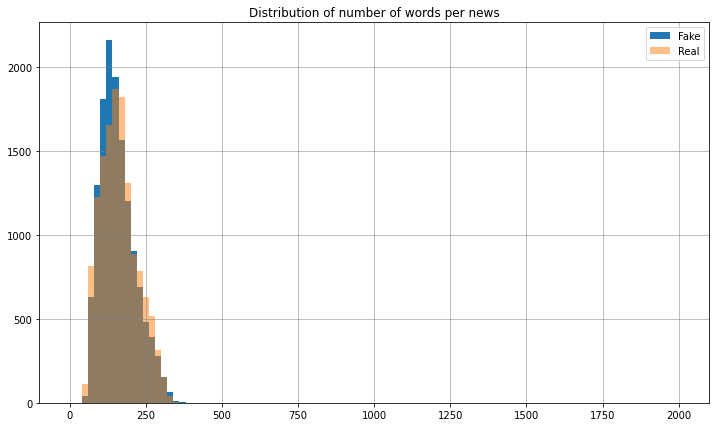

In [176]:
plt.figure(figsize = (12,7))
plt.hist(avg_fake, bins = 100, range = [0, 2000], label='Fake')
plt.hist(avg_real, bins = 100, range = [0, 2000], alpha=0.5, label='Real')
plt.legend(loc='upper right')
plt.title('Distribution of number of words per news')
plt.grid(color='gray', linestyle='-', linewidth=0.5)
plt.show()

In [177]:
#Five-numbers summary for each corpus 
def five_num_summary(dataframe):
    quartiles = np.percentile([len(x.split()) for x in dataframe["text"].tolist()], [0, 25, 50, 75, 100])
    
    return quartiles

true_summ = five_num_summary(dataset_real)

print("Text length - Five-number summary for true news:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, int(true_summ[i//25])))
    
    
print("\n")


fake_summ = five_num_summary(dataset_fake)

print("Text length - Five-number summary for fake news:")
for i in range(0, 101,25):
    print("{}'th %ile: {}".format(i, int(fake_summ[i//25])))

Text length - Five-number summary for true news:
0'th %ile: 42
25'th %ile: 117
50'th %ile: 156
75'th %ile: 198
100'th %ile: 359


Text length - Five-number summary for fake news:
0'th %ile: 44
25'th %ile: 116
50'th %ile: 148
75'th %ile: 192
100'th %ile: 378


In [178]:
#Checking examples of the shortest fake news
X_fake_sorted = sorted(X_fake, key = len)
print(X_fake_sorted[:5])

[['rex', 'smokes', 'rude', 'questions', 'relationship', 'secret', 'rex', 'kind', 'bombarded', 'rude', 'questions', 'committed', 'staying', 'position', 'long', 'stay', 'relationship', 'welcome', 'qatari', 'rex', 'style', 'transcript', 'exchange', 'excellency', 'welcome', 'thani', 'thank', 'thani', 'thank', 'receiving', 'thank', 'thank', 'question', 'committed', 'staying', 'position', 'anywhere', 'question', 'long', 'stay', 'long', 'lets', 'question', 'relationship'], ['ron', 'paul', 'pick', 'david', 'texas', 'ron', 'paul', 'front', 'runner', 'wins', 'nomination', 'saying', 'views', 'scope', 'authority', 'surpass', 'paul', 'business', 'network', 'asked', 'billionaire', 'businessman', 'win', 'nomination', 'opposite', 'libertarian', 'paul', 'candidate', 'probably', 'different', 'rodham', 'front', 'runner', 'die', 'hard', 'neoconservatives', 'extremely', 'unhappy', 'paul', 'efficient', 'using', 'orders', 'say', 'arrogant', 'write', 'order', 'continue', 'century', 'files'], ['ron', 'paul', '

In [179]:
#Checking examples of the shortest real news
X_real_sorted = sorted(X_real, key = len)
print(X_real_sorted[:5])

[['abe', 'agree', 'boost', 'deterrence', 'japanese', 'shinzo', 'abe', 'boost', 'response', 'program', 'phone', 'call', 'strengthen', 'deterrence', 'capability', 'threat', 'deputy', 'cabinet', 'pyongyang', 'fired', 'appeared', 'intercontinental', 'ballistic', 'waters', 'exclusive', 'zone', 'abe', 'needs', 'play', 'increased', 'role', 'countering', 'discuss', 'options', 'toward', 'cabinet', 'separate', 'conference', 'work', 'closely', 'response', 'launch'], ['call', 'tougher', 'chancellor', 'angela', 'condemned', 'test', 'quickly', 'agree', 'tougher', 'pyongyang', 'test', 'hydrogen', 'bomb', 'means', 'unacceptable', 'escalation', 'regime', 'steffen', 'seibert', 'spoke', 'telephone', 'chancellor', 'expressed', 'view', 'community', 'must', 'continue', 'exert', 'regime', 'quickly', 'adopt', 'stricter', 'seibert', 'part', 'push', 'tougher', 'seibert', 'adding', 'aim', 'dissuade', 'violations', 'achieve', 'peaceful', 'solution'], ['pregnant', 'teenager', 'moved', 'pentagon', 'moved', 'years',

Total #unique words, avg #unique words/news

In [180]:
cnt_real = Counter()
for news in X_real:
  for word in news:
    cnt_real[word] += 1

cnt_fake = Counter()
for news in X_fake:
  for word in news:
    cnt_fake[word] += 1

print("Total unique words in real news: ",len(cnt_real))
print("Total unique words in fake news: ",len(cnt_fake))

Total unique words in real news:  31605
Total unique words in fake news:  31605


Total #char per news, avg #char per news

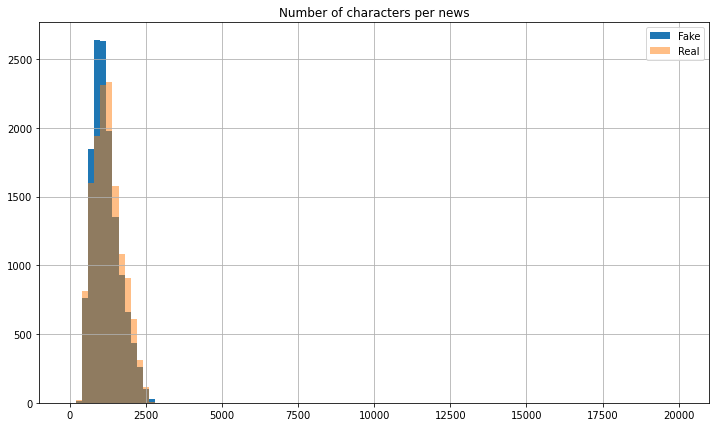

In [181]:
#Comparison of news lengths in characters number between Real and Fake news
plt.figure(figsize = (12,7))
dataset_fake['text'].str.len().hist(bins = 100, range = [0, 20000])
dataset_real['text'].str.len().hist(alpha=0.5, bins = 100, range = [0, 20000])
plt.title('Number of characters per news')
plt.legend(['Fake', 'Real'])
plt.show()

In [182]:
from statistics import mean
print("Real mean news length (in words #): ",mean(dataset_real['text'].str.len()))
print("Fake mean news length (in words #): ",mean(dataset_fake['text'].str.len()))

Real mean news length (in words #):  1253.594261392823
Fake mean news length (in words #):  1189.3308138254936


## Words frequency

In [0]:
#Word Cloud on real news
text = ''
for news in dataset_real.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del text

In [0]:
#Word Cloud on fake news
text = ''
for news in dataset_fake.text.values:
    text += news
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = set(nltk.corpus.stopwords.words("english"))).generate(text)
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
del text

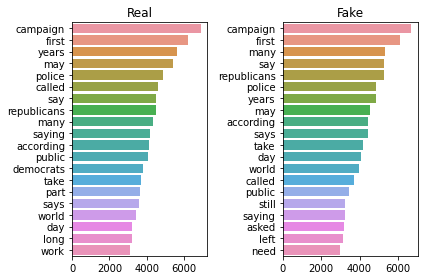

In [184]:
#Let's analyze most frequent words
corpus_real=[word for i in X_real for word in i]
counter_real=Counter(corpus_real)
most_real=counter_real.most_common()

x1, x2= [], []
for word,count in most_real[:40]:
    if (word not in stop_words and len(word) > 1):
        x1.append(word)
        x2.append(count)
 
corpus_fake=[word for j in X_fake for word in j]
counter_fake=Counter(corpus_fake)
most_fake=counter_fake.most_common()

x3, x4= [], []
for word,count in most_fake[:40]:
    if (word not in stop_words and len(word) > 1):
        x3.append(word)
        x4.append(count)

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=x2[:20],y=x1[:20],ax=ax1).set_title('Real')
sns.barplot(x=x4[:20],y=x3[:20],ax=ax2).set_title('Fake')
fig.tight_layout()

Bigrams and trigrams in both classes

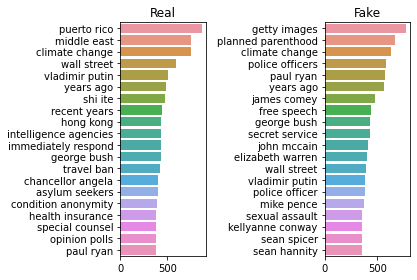

In [183]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(stop_words='english', lowercase=True, ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

top_n_bigrams_real=get_top_ngram(dataset_real['text'],2)[:20]
x_,y_=map(list,zip(*top_n_bigrams_real))
top_n_bigrams_fake=get_top_ngram(dataset_fake['text'],2)[:20]
w_,z_=map(list,zip(*top_n_bigrams_fake))

fig,(ax1, ax2) = plt.subplots(1,2)
sns.barplot(x=y_,y=x_,ax=ax1).set_title('Real')
sns.barplot(x=z_,y=w_,ax=ax2).set_title('Fake')
fig.tight_layout()

## TF-IDF, k-means (to be continued)

In [0]:
#Alternative method of analyzing ngrams via TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
class NewTfidfVectorizer(TfidfVectorizer):
    def _word_ngrams(self, tokens, stop_words=None):

        # First get tokens without stop words
        tokens = super(TfidfVectorizer, self)._word_ngrams(tokens, None)
        if stop_words is not None:
            new_tokens=[]
            for token in tokens:
                split_words = token.split(' ')

                # Only check the first and last word for stop words
                if split_words[0] not in stop_words and split_words[-1] not in stop_words:
                    new_tokens.append(token)
            return new_tokens

        return tokens

vectorizer = NewTfidfVectorizer(stop_words='english', ngram_range=(3,3))
vectorizer.fit(bert_dataset["text"])

In [0]:
#K-means
#we can also pursue dimensionality reduction using LSA (I can write this code) if we want to improve further.
X_vec = vectorizer.fit_transform(bert_dataset['text'])
labels = bert_dataset['class']
true_k = np.unique(labels).shape[0]

km = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,init_size=1000, 
                     batch_size=1000, verbose=False)
print("Clustering sparse data with %s" % km)
km.fit(X_vec)

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f" % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_vec, km.labels_, sample_size=1000))

print()

## Topic Modeling exploration with pyLDAvis

In [0]:
#Tokenization and lemmatization
from nltk.stem import PorterStemmer, WordNetLemmatizer

def preprocess_news(df):
    corpus=[]
    stem=PorterStemmer()
    lem=WordNetLemmatizer()
    for news in df['text']:
        words=[w for w in nltk.word_tokenize(news) if (w not in stop_words)]
        
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        
        corpus.append(words)
    return corpus

corpus_real=preprocess_news(dataset_real)
corpus_fake=preprocess_news(dataset_fake)

In [0]:
#Let’s create the bag of words model using gensim
dic_real=gensim.corpora.Dictionary(corpus_real)
bow_corpus_real = [dic_real.doc2bow(doc_real) for doc_real in corpus_real]

dic_fake=gensim.corpora.Dictionary(corpus_fake)
bow_corpus_fake = [dic_fake.doc2bow(doc_fake) for doc_fake in corpus_fake]

In [0]:
#And finally create the LDA models
lda_model_real = gensim.models.LdaMulticore(bow_corpus_real, 
                                   num_topics = 4, 
                                   id2word = dic_real,                                    
                                   passes = 10,
                                   workers = 2)
lda_model_real.show_topics()

In [0]:
#And finally create the LDA models
lda_model_fake = gensim.models.LdaMulticore(bow_corpus_fake, 
                                   num_topics = 4, 
                                   id2word = dic_fake,                                    
                                   passes = 10,
                                   workers = 2)
lda_model_fake.show_topics()

In [0]:
%%capture
!pip install pyLDAvis

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_real = pyLDAvis.gensim.prepare(lda_model_real, bow_corpus_real, dic_real)
vis_real

In [0]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis_fake = pyLDAvis.gensim.prepare(lda_model_fake, bow_corpus_fake, dic_fake)
vis_fake

## Readibility index (using Flesch reading ease score formula)

*   90-100 : Very Easy
*   80-89 : Easy
*   70-79 : Fairly Easy
*   60-69 : Standard
*   50-59 : Fairly Difficult
*   30-49 : Difficult
*   0-29 : Very Confusing

The formula for calculating the flesch reading easiness score is given below:

RE = 206.835 – (1.015 x ASL) – (84.6 x ASW)

RE = Readability Ease

ASL = Average Sentence Length (i.e., the number of words divided by the number of sentences)

ASW = Average number of syllables per word (i.e., the number of syllables divided by the number of words)

In [0]:
%%capture
!pip install textstat

In [0]:
#The analysis must be performed on the original dataset, before data preprocessing
import textstat as ts

real_news_readability = []
fake_news_readability = []

for sentence in dataset.loc[dataset['class'] == 1]["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    real_news_readability.append(temp)
    
for sentence in dataset.loc[dataset['class'] == 0]["text"].tolist():
    temp = ts.flesch_reading_ease(sentence)
    fake_news_readability.append(temp)

In [0]:
real_readability_df = pd.Series(real_news_readability)
fake_readability_df = pd.Series(fake_news_readability)

plt.figure(figsize = (12,7))
plt.hist(fake_readability_df, bins = 10, range = [0, 100], label = "fake-news readability")
plt.hist(real_readability_df, bins = 10, range = [0, 100], alpha = 0.5, label = "real-news readability")
plt.xlabel("Flesch readability easiness for a news article", fontsize = 12)
plt.ylabel("Number of articles with x word length", fontsize = 12)
plt.title("Class wise Flesch readability ease score distribution", fontsize = 15)
plt.legend()
plt.show()

## Sentiment analysis

With Vader library

```
Vader uses a bag of words approach (a lookup table of positive and negative words) with some simple heuristics (e.g. increasing the intensity of the sentiment if some words like “really”, “so” or “a bit” are present).`
The advantage of this approach is that sentences containing negated positive words (e.g. “not happy”, “not good”) will still receive a negative sentence sentiment (thanks to the heuristics to flip the sentiment of the word following a negation).
Vader is sensitive to punctuation, capitalization, degree modifiers, Preceding Tri-gram
```
The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.
*   Positive sentiment: compound score >= 0.05
*   Neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
*   Negative sentiment: compound score <= -0.05

The pos, neu, and neg scores are ratios for proportions of text that fall in each category. These are the most useful metrics if you want multidimensional measures of sentiment for a given sentence.

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

In [0]:
vader.polarity_scores('this is great')

In [0]:
def get_vader_sent(val):
  if val >= 0.05:
    return "pos"
  elif val <= -0.05:
    return "neg"
  else:
    return "neu"

In [0]:
# Checking with non preprocessed data (hence including punctuation, upper case, etc.)
vader_real = []
sentiments_real = dataset.loc[dataset['class'] == 1]["text"].tolist()

for i in range(len(sentiments_real)):
  vader_real.append(vader.polarity_scores(str(sentiments_real[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_real)):
  comp.append(vader_real[j]['compound'])
  pos.append(vader_real[j]['pos'])
  neg.append(vader_real[j]['neg'])
  neu.append(vader_real[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

In [0]:
sent_real = [get_vader_sent(x) for x in comp]
sent_real[:10]

In [0]:
vader_fake = []
sentiments_fake = dataset.loc[dataset['class'] == 0]["text"].tolist()

for i in range(len(sentiments_fake)):
  vader_fake.append(vader.polarity_scores(sentiments_fake[i]))

comp_fake = []
pos_fake = []
neg_fake = []
neu_fake = []
for j in range(len(vader_fake)):
  comp_fake.append(vader_fake[j]['compound'])
  pos_fake.append(vader_fake[j]['pos'])
  neg_fake.append(vader_fake[j]['neg'])
  neu_fake.append(vader_fake[j]['neu'])

print("Compound: ",sum(comp_fake)/len(comp_fake), "Positive: ",sum(pos_fake)/len(pos_fake),"Neutral: ", sum(neu_fake)/len(neu_fake),"Negative :", sum(neg_fake)/len(neg_fake))

In [0]:
sent_fake = [get_vader_sent(x) for x in comp_fake]
sent_fake[:10]

In [0]:
real_unique, real_count = np.unique(sent_real, return_counts=True)
fake_unique, fake_count = np.unique(sent_fake, return_counts=True)
vader_sent = pd.DataFrame(data={'sentiments':real_unique, 'Fake':fake_count, "Real":real_count})

ax = vader_sent.plot.bar()
ax.set(xticklabels = vader_sent['sentiments'])
plt.legend(loc='upper center')
plt.title('Sentiment distribution of news corpus')
plt.show()

In [0]:
# Checking the same with preprocessed data (without punctuation, upper case, etc.)
vader_real = []
sentiments_real_bert = bert_dataset.loc[bert_dataset['class'] == 1]["text"].tolist()

for i in range(len(sentiments_real_bert)):
  vader_real.append(vader.polarity_scores(str(sentiments_real_bert[i])))

comp = []
pos = []
neg = []
neu = []
for j in range(len(vader_real)):
  comp.append(vader_real[j]['compound'])
  pos.append(vader_real[j]['pos'])
  neg.append(vader_real[j]['neg'])
  neu.append(vader_real[j]['neu'])

print("Compound: ",sum(comp)/len(comp), "Positive: ",sum(pos)/len(pos),"Neutral: ", sum(neu)/len(neu),"Negative :", sum(neg)/len(neg))

In [0]:
vader_fake = []
sentiments_fake_bert = bert_dataset.loc[bert_dataset['class'] == 0]["text"].tolist()

for i in range(len(sentiments_fake_bert)):
  vader_fake.append(vader.polarity_scores(sentiments_fake_bert[i]))

comp_fake = []
pos_fake = []
neg_fake = []
neu_fake = []
for j in range(len(vader_fake)):
  comp_fake.append(vader_fake[j]['compound'])
  pos_fake.append(vader_fake[j]['pos'])
  neg_fake.append(vader_fake[j]['neg'])
  neu_fake.append(vader_fake[j]['neu'])

print("Compound: ",sum(comp_fake)/len(comp_fake), "Positive: ",sum(pos_fake)/len(pos_fake),"Neutral: ", sum(neu_fake)/len(neu_fake),"Negative :", sum(neg_fake)/len(neg_fake))

In [0]:
sent_bert_real = [get_vader_sent(x) for x in comp]
sent_bert_fake = [get_vader_sent(x) for x in comp_fake]

bert_real_unique, bert_real_count = np.unique(sent_bert_real, return_counts=True)
bert_fake_unique, bert_fake_count = np.unique(sent_bert_fake, return_counts=True)
vader_bert_sent = pd.DataFrame(data={'sentiments':bert_real_unique, 'Fake':bert_fake_count, "Real":bert_real_count})

ax = vader_bert_sent.plot.bar()
ax.set(xticklabels = vader_bert_sent['sentiments'])
plt.legend(loc='upper center')
plt.title('Sentiment distribution of news corpus')
plt.show()

In [0]:
vader.polarity_scores(sentiments_real[10])

With TextBlob


```
TextBlob uses a bag of words classifier, but the advantage is that it includes Subjectivity Analysis too (how factual/opinionated a piece of text is).
However, it doesn’t contain the heuristics that NLTK has, and so it won’t intensify or negate a sentence’s sentiment.
```


*   polarity: negative vs. positive    (-1.0 => +1.0)
*   subjectivity: objective vs. subjective (+0.0 => +1.0)



In [0]:
from textblob import TextBlob
TextBlob(sentiments_real[10]).sentiment


In [0]:
# Checking with non preprocessed data (hence including punctuation, upper case, etc.)
pol_real = []
subj_real = []

for i in range(len(sentiments_real)):
  pol_real.append(TextBlob(sentiments_real[i]).sentiment.polarity)
  subj_real.append(TextBlob(sentiments_real[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_real), "Subjectivity: ",mean(subj_real))

In [0]:
pol_fake = []
subj_fake = []

for i in range(len(sentiments_fake)):
  pol_fake.append(TextBlob(sentiments_fake[i]).sentiment.polarity)
  subj_fake.append(TextBlob(sentiments_fake[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_fake), "Subjectivity: ",mean(subj_fake))

In [0]:
# Checking the same with preprocessed data (without punctuation, upper case, etc.)
pol_real = []
subj_real = []

for i in range(len(sentiments_real_bert)):
  pol_real.append(TextBlob(sentiments_real_bert[i]).sentiment.polarity)
  subj_real.append(TextBlob(sentiments_real_bert[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_real), "Subjectivity: ",mean(subj_real))


In [0]:
pol_fake = []
subj_fake = []

for i in range(len(sentiments_fake_bert)):
  pol_fake.append(TextBlob(sentiments_fake_bert[i]).sentiment.polarity)
  subj_fake.append(TextBlob(sentiments_fake_bert[i]).sentiment.subjectivity)

print("Polarity: ",mean(pol_fake), "Subjectivity: ",mean(subj_fake))

In [0]:
plt.figure(figsize = (12,7))
plt.hist(subj_fake, bins = 100, range = [0, 1], label='Fake')
plt.hist(subj_real, bins = 100, range = [0, 1], alpha=0.5, label='Real')
plt.legend(loc='upper right')
plt.title('Subjectivity distribution of news corpus')
plt.show()

With Fair


```
Flair’s sentiment classifier is based on a character-level LSTM neural network which takes sequences of letters and words into account when predicting.
The network has learnt to take negations into account, as well as intensifiers.
It can also predict OOV words that it has never seen before (contrary to the 2 other libraries)
```



In [0]:
#%%capture
#!pip3 install flair
#import flair

In [0]:
#flair_sentiment = flair.models.TextClassifier.load('en-sentiment')
#s = flair.data.Sentence(sentiments_real[10])
#flair_sentiment.predict(s)
#total_sentiment = s.labels
#total_sentiment

## Naive Bayes Text feature importance

In [0]:
NUM_FEATURES = 20

# getting the indexes of the top features by class
fake_prob_sorted = naive_bayes_model.feature_log_prob_[0, :].argsort()[::-1]
real_prob_sorted = naive_bayes_model.feature_log_prob_[1, :].argsort()[::-1]

# getting the top feature names
fake_top_features = np.take(vectorizer.get_feature_names(), fake_prob_sorted[:NUM_FEATURES])
real_top_features = np.take(vectorizer.get_feature_names(), real_prob_sorted[:NUM_FEATURES])

# creating dictionaries for each class with the feature name and log probability
real_dict = {k:v for k, v in zip(
                                real_top_features, 
                                np.take(naive_bayes_model.feature_log_prob_[1, :], real_prob_sorted[:NUM_FEATURES])
                                )
            }

fake_dict = {k:v for k, v in zip(
                                fake_top_features, 
                                np.take(naive_bayes_model.feature_log_prob_[0, :], fake_prob_sorted[:NUM_FEATURES])
                                )
            }

In [119]:
# creating a dataframe using the dictionaries of top terms per class
top_terms = pd.DataFrame.from_dict(real_dict, orient='index')
top_terms.reset_index(inplace=True)
top_terms.rename(columns={'index': 'term', 0: 'log_prob'}, inplace=True)
top_terms['label'] = 'Real'

# add the top terms for the fake class
for term, log_prob in fake_dict.items():
    top_terms = top_terms.append({'term': term, 'log_prob': log_prob, 'label': 'Fake'}, ignore_index=True)

# convert log probability to odds ratio
top_terms['odds'] = top_terms.log_prob.apply(np.exp)

# sort alphabetically
top_terms = top_terms.sort_values('term', ascending=True)

top_terms.head(10)

,term,log_prob,label,odds
13,according,-7.270541,Real,0.000696
32,according,-7.176296,Fake,0.000764
37,asked,-7.350684,Fake,0.000642
7,called,-7.138040,Real,0.000794
0,campaign,-6.750620,Real,0.001170
20,campaign,-6.698565,Fake,0.001233
35,candidate,-7.332884,Fake,0.000654
30,day,-7.168621,Fake,0.000770
34,democrats,-7.294168,Fake,0.000679
6,democrats,-7.101516,Real,0.000824


In [0]:
# creating dictionary to be used for plotting
top_terms["idx"]=range(0,len(top_terms))
y_map = top_terms["term"][:NUM_FEATURES*2]
#y_map = {term: y for y, term in zip(range(0, top_terms.shape[0]), top_terms.term)}

plot_map = {} 
for index, row in top_terms.iterrows():
    term = row['term']
    if term in plot_map:
      term = term+" "
    
    plot_map[term] = {
        'x': row['odds'],
        'y': row['idx'],
#        'y': y_map[term],
        'c': 'red' if row['label'] == 'Fake' else 'blue'
    } 

No handles with labels found to put in legend.


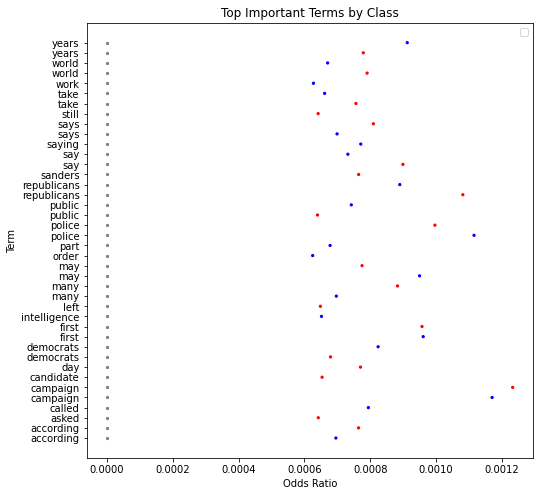

In [121]:
# plotting
fig = plt.figure(figsize=(8, 8))
_ = plt.scatter(
            [value['x'] for key, value in plot_map.items()], 
            [value['y'] for key, value in plot_map.items()],
            s=5,
            color=[value['c'] for key, value in plot_map.items()],
)

_ = plt.scatter(
    [0]* top_terms.shape[0],
    [r for r in range(0, top_terms.shape[0])],
    s=5,
    color='grey'
)

plt.legend()
plt.yticks(ticks=[r for r in range(0, top_terms.shape[0])], labels=y_map)
plt.xlabel('Odds Ratio')
plt.ylabel('Term')
plt.title('Top Important Terms by Class')
plt.show()

## K-Means on W2V vectors

In [0]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from itertools import cycle

def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++')
    idx = kmeans_clustering.fit_predict(word_vectors)
    
    return kmeans_clustering.cluster_centers_, idx

def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers]
    closest_words_idxs = [x[1] for x in closest_points]

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {}
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words)
    df.index = df.index+1

    return df

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


def display_cloud(cluster_num, cmap, words_df):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap)
    wordcloud = wc.generate(' '.join([word for word in words_df['Cluster #' + str(cluster_num).zfill(2)]]))
    plt.figure(cluster_num)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
#    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')


cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

NUM_CLUSTERS = 10
EMBEDDING_DIM = 100

In [0]:
w2v_model_real = gensim.models.Word2Vec(sentences=X_real, size=EMBEDDING_DIM, window=5, min_count=5)
w2v_model_fake = gensim.models.Word2Vec(sentences=X_fake, size=EMBEDDING_DIM, window=5, min_count=5)

Starting with Fake news

In [0]:
centers_fake, clusters_fake = clustering_on_wordvecs(w2v_model_fake.wv.syn0, NUM_CLUSTERS)
centroid_map_fake = dict(zip(w2v_model_fake.wv.index2word, clusters_fake))

In [125]:
#Getting words in each cluster that are closest to the cluster center
top_words_fake = get_top_words(w2v_model_fake.wv.index2word, 20, centers_fake, w2v_model_fake.wv.syn0)
top_words_fake

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10
1,butter,hathaway,pretending,stabbing,candidacy,solely,mails,recipients,blade,dave
2,ireland,uttar,pretend,fled,primaries,strict,contacts,profits,strips,martha
3,morocco,fetullah,insanity,nearby,bid,preventing,reviewed,amounts,tin,lawrence
4,boasting,wmt,pure,pulse,swing,impose,memos,expensive,injected,craig
5,overwhelmed,toasted,treating,alton,unpopular,initiatives,communication,investors,decimated,katy
6,wt,bac,believing,stabbed,endorse,adopt,confidential,wages,rides,rob
7,mount,mohanad,narcissist,bullets,opponent,exempt,guccifer,manufacturing,visually,legendary
8,angle,andes,sane,filming,rival,restrict,veselnitskaya,salary,greeks,hayes
9,von,traversing,narcissistic,castile,flip,moreover,subpoena,fewer,remnants,carl
10,poop,njt,whenever,parking,gore,sovereign,briefed,deficit,beard,howard


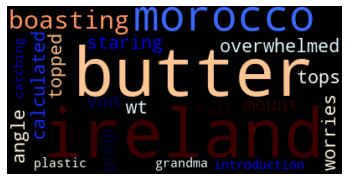

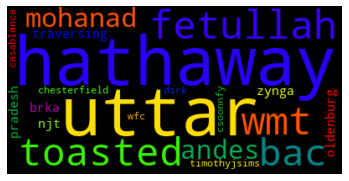

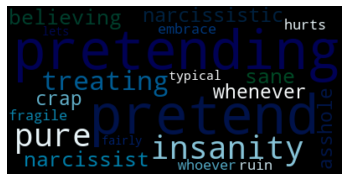

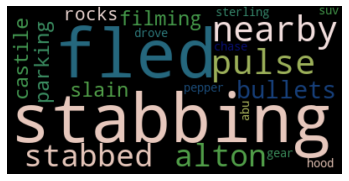

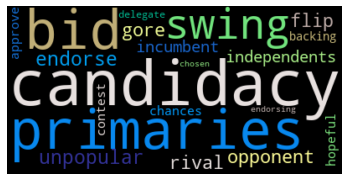

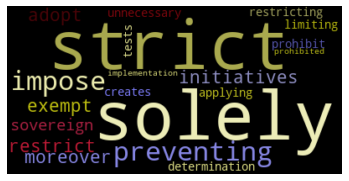

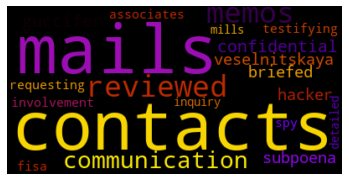

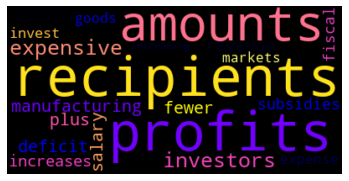

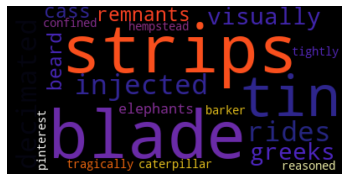

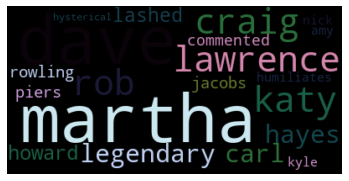

In [126]:
#Displaying clusters via WordClouds
for fi in range(NUM_CLUSTERS):
    col = next(cmaps)
    display_cloud(fi+1, col, top_words_fake)


And with Real news

In [0]:
centers_real, clusters_real = clustering_on_wordvecs(w2v_model_real.wv.syn0, NUM_CLUSTERS)
centroid_map_real = dict(zip(w2v_model_real.wv.index2word, clusters_real))

In [128]:
#Getting words in each cluster that are closest to the cluster center
top_words_real = get_top_words(w2v_model_real.wv.index2word, 20, centers_real, w2v_model_real.wv.syn0)
top_words_real

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10
1,piercing,jay,outskirts,achieving,runoff,examining,mansour,generate,dancer,directive
2,bouquets,brian,checkpoint,realistic,tight,leaking,peacekeepers,incentives,pure,violates
3,ridiculously,schultz,burnt,meaningful,scored,unrelated,presence,earnings,shoulders,amend
4,waad,williams,blew,broadly,socialists,revealed,territories,lowering,soup,statute
5,bestiality,leahy,attacker,objective,undecided,confidential,commanders,costly,tale,barring
6,stewed,amy,exploded,solved,electorate,cooperating,belarus,reductions,tongue,overturn
7,miley,debbie,buried,stressing,predicted,misleading,ghani,offset,gucci,prohibits
8,phillipe,murphy,escaped,complicate,loses,inquiries,annexed,hikes,aboriginal,injunction
9,necklace,blumenthal,crashed,negotiation,pd,files,jihadists,deductions,koran,protects
10,slob,jon,bangkok,practical,polled,improper,aligned,deficits,comic,waivers


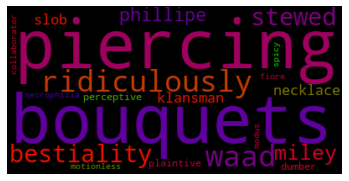

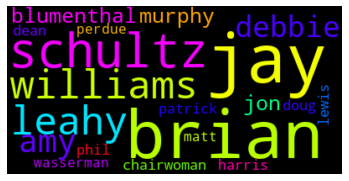

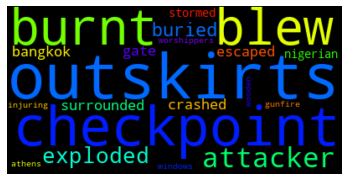

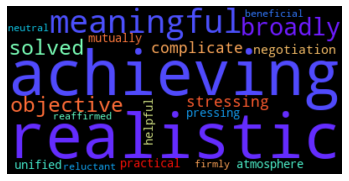

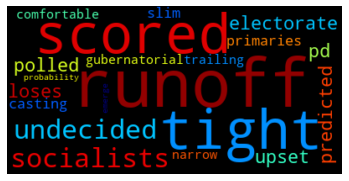

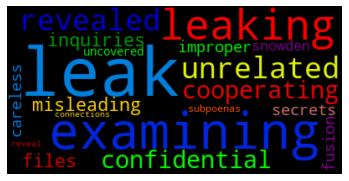

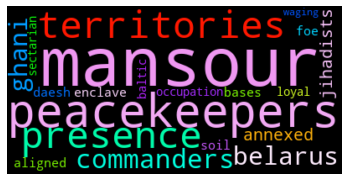

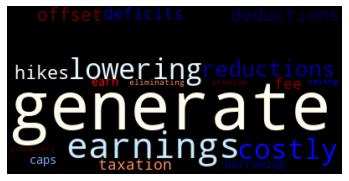

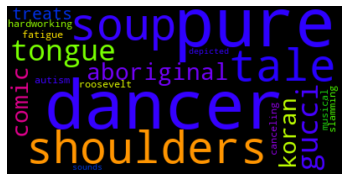

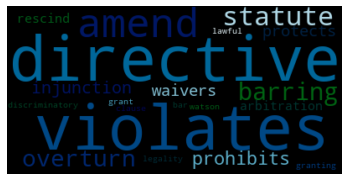

In [129]:
#Displaying clusters via WordClouds
for ri in range(NUM_CLUSTERS):
    col = next(cmaps);
    display_cloud(ri+1, col, top_words_real)